# Named-Entity Recognition
Implementation of a NER tagger following Chiu-Nichols' paper (2016): 
Named Entity Recognition with Bidirectional LSTM-CNNs.

Author: Pierre Nugues

## A Note on the Performance

Chiu and Nichols reported a maximal performance of 91.62 on the CoNLL 2003 English corpus. The performance we obtain here is not completely comparable to theirs as we have a slightly different configuration:
* The program below uses word and character features only. It sets aside the capitalization and lexicons features proposed by Chiu and Nichols. We believe this makes our program more easily adaptable to other languages. 
* In addition, Chiu and Nichols trained their model on the training and development sets. We only use the training set.

Nonetheless, we can try to compare their figures with ours. In Table 6 of their paper, Chiu and Nichols report a best performance of 91.62 with a model trained on the training and development sets with all the features. When trained on the training set only, they reached 91.23 (Table 8). From this, we can estimate that the contribution of the development set is of about 91.62 - 91.23 ~= 0.39. 

When using the word and character features and training their model on the training and development sets, Chiu and Nichols trained 90.91 (Table 6, second row, BLSTM-CNN). We can posit that Chiu and Nichols' system trained on the training set only would reach 90.91 - 0.39 ~= 90.52. This figure should be considered as an average over multiple runs (five to 10).

## Preliminaries

The imported modules

In [1]:
import sys
import os
import time
import numpy as np
from tqdm import tqdm
from random import shuffle
from keras import callbacks
from keras.initializers import RandomUniform
from keras.models import Sequential, Input
from keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed, concatenate
from keras.layers import LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras_contrib.layers import CRF
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Using TensorFlow backend.


A few functions we'll be using

In [2]:
sys.path.append('/Users/pierre/Documents/Cours/EDAN20/programs/')

from ch06.python.conll_dictorizer import CoNLLDictorizer
from ch08.python.datasets import load_conll2003_en, load_glove_vectors
from ch08.python.rnn_preprocessing import build_sequences, to_index, to_char_index

Different possible configurations, including those from Chiu-Nichols

In [3]:
OPTIMIZER = 'rmsprop'
ANNOTATION = 'IOBES'  # 'IOBES' or 'IOB'
EMBEDDING_DIM = 100
BATCH_SIZE =  512 # Chiu-Nichols 8
EPOCHS = 80 # Chiu-Nichols 80
LSTM_UNITS = 200 # Chiu-Nichols 275
CHAR_EMBEDDING_DIM = 50  # Chiu-Nichols 25
CHAR_UNITS = 50  # Chiu-Nichols 53
CHAR_DROPOUT = 0.5 # Chiu-Nichols 0?
DROPOUT_RATE_PRE = 0.5 # Dropout before the LSTM
RECURRENT_DROPOUT = 0.5 # Chiu-Nichols 0?
DROPOUT_RATE = 0.0 # Chiu-Nichols 0.68?
DROPOUT_RATE_POST = 0.0 # Dropout after the LSTM # Chiu-Nichols 0.0?
MAX_LEN_CHARS = 20 # 10 or 20
RAND_INIT_RANGE = 0.05
ADD_CRF = True

VILDE = False  # The computing machine

config = {'Optimizer': OPTIMIZER, 'Annotation': ANNOTATION,
          'Batch size': BATCH_SIZE, 'Epochs': EPOCHS, 'LSTM units': LSTM_UNITS,
          'Char embedding dim': CHAR_EMBEDDING_DIM, 'Embedding dim': EMBEDDING_DIM,
         'Char dropout': CHAR_DROPOUT, 'Pre dropout': DROPOUT_RATE_PRE, 
          'Recurrent dropout': RECURRENT_DROPOUT, 'Dropout': DROPOUT_RATE, 
          'Post dropout': DROPOUT_RATE_POST, 'CRF': ADD_CRF}

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

## Creating the $\mathbf{X}$ and $\mathbf{Y}$ matrices

In [5]:
print('Configuration::', config)
start_time = time.perf_counter()
if ANNOTATION == 'IOBES':
    if VILDE:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='./')
    else:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(BASE_DIR='./IOBES/')
else:
    if VILDE:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='/home/pierre/Cours/EDAN20/corpus/CoNLL2003/')
    else:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='/Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/IOB/')

conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)
print('Second sentence, CoNLL rows:', train_dict[1])

X_train_word_cat, Y_train_cat = build_sequences(train_dict, key_x='form', key_y='ner', tolower=False)
X_dev_word_cat, Y_dev_cat = build_sequences(dev_dict, key_x='form', key_y='ner', tolower=False)
X_test_word_cat, Y_test_cat = build_sequences(test_dict, key_x='form', key_y='ner', tolower=False)
print('Second sentence, words', X_train_word_cat[1])
print('Second sentence, NER', Y_train_cat[1])

# We collect the words, named entity tags, and we create the indices
vocabulary_words_train = [word
                               for sentence in X_train_word_cat
                               for word in sentence]
vocabulary_words_dev = [word
                               for sentence in X_dev_word_cat
                               for word in sentence]
vocabulary_words_test = [word
                               for sentence in X_test_word_cat
                               for word in sentence]

Configuration:: {'Optimizer': 'rmsprop', 'Annotation': 'IOBES', 'Batch size': 512, 'Epochs': 80, 'LSTM units': 200, 'Char embedding dim': 50, 'Embedding dim': 100, 'Char dropout': 0.5, 'Pre dropout': 0.5, 'Recurrent dropout': 0.5, 'Dropout': 0.0, 'Post dropout': 0.0, 'CRF': True}
Second sentence, CoNLL rows: [{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'S-NP', 'ner': 'S-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'S-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'S-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'E-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'E-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'S-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'E-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]
Second sentence, words ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Second sentence

As vocabulary, we first extract the words in the training set

In [6]:
vocabulary_words = vocabulary_words_train
#vocabulary_words.extend(vocabulary_words_dev)
#vocabulary_words.extend(vocabulary_words_test)
vocabulary_words = list(set(vocabulary_words))
print('#words:', len(vocabulary_words))

#words: 23624


We extract all the characters

In [7]:
MAX_LEN_CHARS_OBSERVED = max([len(word) for word in vocabulary_words])
print('Word maximal length', MAX_LEN_CHARS_OBSERVED)
chars = set(' ')
for word in vocabulary_words:
    chars.update(set(word))
chars = sorted(list(chars))

NB_CHARS = len(chars)
print('#chars:', NB_CHARS)

Word maximal length 61
#chars: 85


We build the complete vocabulary: the words from the training set and those from glove

In [8]:
# We read the embeddings
if VILDE:
    embeddings_dict = load_glove_vectors(
        BASE_DIR='/home/pierre/Cours/EDAN20/corpus/')
else:
    embeddings_dict = load_glove_vectors()
embeddings_words = embeddings_dict.keys()
print('#words in GloVe:', len(embeddings_dict.keys()))
vocabulary_words = sorted(set(vocabulary_words +
                              list(embeddings_words)))
print('# unique words in the vocabulary: embeddings and corpus:',
      len(vocabulary_words))

#words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 411650


We set all the words in lowed case

In [9]:
vocabulary_words = set(map(str.lower, vocabulary_words))
print('# unique lowercased words in the vocabulary: embeddings and corpus:',
      len(vocabulary_words))

# unique lowercased words in the vocabulary: embeddings and corpus: 402595


We extract all the named entity tags: The classes

In [10]:
ner = sorted(set([ner
                  for sentence in Y_train_cat
                  for ner in sentence]))
NB_CLASSES = len(ner)
print(NB_CLASSES, 'named entity tags:', ner)

17 named entity tags: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'E-LOC', 'E-MISC', 'E-ORG', 'E-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O', 'S-LOC', 'S-MISC', 'S-ORG', 'S-PER']


In [11]:
# We create the indexes
# For the words and chars, we start at two to make provision for
# the padding symbol 0 in RNN and LSTMs and unknown words/chars, 1
idx2char = dict(enumerate(chars, start=2))
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2ner = dict(enumerate(ner))
char2idx = {v: k for k, v in idx2char.items()}
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}
print('char index:', list(char2idx.items())[:10])
print('word index:', list(word2idx.items())[:10])
print('NER index:', list(ner2idx.items()))

char index: [(' ', 2), ('!', 3), ('"', 4), ('$', 5), ('%', 6), ('&', 7), ("'", 8), ('(', 9), (')', 10), ('*', 11)]
word index: [('chandeliered', 2), ('soco', 3), ('kindel', 4), ('siddhi', 5), ('freeze-dried', 6), ('prominence', 7), ('papagos', 8), ('positively-charged', 9), ('raczki', 10), ('đorđe', 11)]
NER index: [('B-LOC', 0), ('B-MISC', 1), ('B-ORG', 2), ('B-PER', 3), ('E-LOC', 4), ('E-MISC', 5), ('E-ORG', 6), ('E-PER', 7), ('I-LOC', 8), ('I-MISC', 9), ('I-ORG', 10), ('I-PER', 11), ('O', 12), ('S-LOC', 13), ('S-MISC', 14), ('S-ORG', 15), ('S-PER', 16)]


In [12]:
# We create the parallel sequences of indexes for the chars in their original case
X_train_char_idx = to_char_index(X_train_word_cat, char2idx)
X_train_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                            X_train_char_idx))
X_dev_char_idx = to_char_index(X_dev_word_cat, char2idx)
X_dev_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                          X_dev_char_idx))
X_test_char_idx = to_char_index(X_test_word_cat, char2idx)
X_test_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                           X_test_char_idx))

In [13]:
print(MAX_LEN_CHARS)
print(X_train_word_cat[1])
X_train_char_idx[1]

20
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


array([[36, 52,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [78, 65, 70, 65, 63, 80, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [38, 65, 78, 73, 61, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [63, 61, 72, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [80, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [62, 75, 85, 63, 75, 80, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [33, 78, 69, 80, 69, 79, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [72, 61, 73, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32)

In [14]:
# We set the words in lower case.
X_train_word_cat = [[x.lower() for x in x_vect] for x_vect in X_train_word_cat]
X_dev_word_cat = [[x.lower() for x in x_vect] for x_vect in X_dev_word_cat]
X_test_word_cat = [[x.lower() for x in x_vect] for x_vect in X_test_word_cat]

In [15]:
X_train_word_cat[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [16]:
# We create the parallel sequences of indexes for the words
# Train
X_train_word_idx = to_index(X_train_word_cat, word2idx)
Y_train_idx = to_index(Y_train_cat, ner2idx)
# Dev
X_dev_word_idx = to_index(X_dev_word_cat, word2idx)
Y_dev_idx = to_index(Y_dev_cat, ner2idx)
# Test
X_test_word_idx = to_index(X_test_word_cat, word2idx)
Y_test_idx = to_index(Y_test_cat, ner2idx)

In [17]:
print('Train: X_word, Y')
print('Word indices:', X_train_word_idx[:2])
print('NER indices:', Y_train_idx[:2])
print('Dev: X_word, Y')
print('Word indices:', X_dev_word_idx[:2])
print('NER indices:', Y_dev_idx[:2])
print('Test: X_word, Y')
print('Word indices:', X_test_word_idx[:2])
print('NER indices:', Y_test_idx[:2])

Train: X_word, Y
Word indices: [[107675], [113977, 64421, 310929, 178554, 150005, 264977, 11172, 239232, 391086]]
NER indices: [[12], [15, 12, 14, 12, 12, 12, 14, 12, 12]]
Dev: X_word, Y
Word indices: [[107675], [322487, 31741, 209524, 186158, 28624, 238249, 121479, 149583, 262482, 222046, 391086]]
NER indices: [[12], [12, 12, 15, 12, 12, 12, 12, 12, 12, 12, 12]]
Test: X_word, Y
Word indices: [[107675], [190059, 31741, 27971, 81247, 76243, 143033, 217563, 329537, 93692, 76651, 15186, 391086]]
NER indices: [[12], [12, 12, 13, 12, 12, 12, 12, 16, 12, 12, 12, 12]]


In [18]:
print('Train X_chars:', X_train_char_idx[:2])
print('Dev X_chars:', X_dev_char_idx[:2])
print('Test X_chars:', X_test_char_idx[:2])

Train X_chars: [array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), array([[36, 52,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [78, 65, 70, 65, 63, 80, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [38, 65, 78, 73, 61, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [63, 61, 72, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [80, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [62, 75, 85, 63, 75, 80, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [33, 78, 69, 80, 69, 79, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [72, 61, 73, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]]

We initialize the embedding matrix with random values

In [19]:
embedding_matrix = np.random.uniform(-RAND_INIT_RANGE, RAND_INIT_RANGE,
                                     (len(vocabulary_words) + 2,
                                      EMBEDDING_DIM)
                                     ).astype(np.float32)
#embedding_matrix[0, :] = 0.0

In [20]:
# We assign the matrix with Glove embeddings, when they exist
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]

Embeddings

In [21]:
# print('Embedding:', embedding_matrix)
print('Shape of embedding matrix:', embedding_matrix.shape)
print('table:', embedding_matrix[word2idx['table']])
print('padding symbol, idx 0, random numbers:', embedding_matrix[0])
#print('Index of jean-denis:', word2idx['jean-denis'])

Shape of embedding matrix: (402597, 100)
table: [-0.61454    0.89693    0.56771    0.39102   -0.22437    0.49035
  0.10868    0.27411   -0.23833   -0.52153    0.73551   -0.32654
  0.51304    0.32415   -0.46709    0.68051   -0.25497   -0.040484
 -0.54418   -1.0548    -0.46692    0.23557    0.31234   -0.34537
  0.14793   -0.53745   -0.43215   -0.48724   -0.51019   -0.9051
 -0.17919   -0.018376   0.09719   -0.31623    0.7512     0.92236
 -0.49965    0.14036   -0.28296   -0.97443   -0.0094408 -0.62944
  0.14711   -0.94376    0.0075222  0.18565   -0.99172    0.072789
 -0.18474   -0.52901    0.38995   -0.45677   -0.21932    1.3723
 -0.29636   -2.2342    -0.36667    0.04987    0.63421    0.53275
 -0.53955    0.31398   -0.44698   -0.38389    0.066668  -0.02168
  0.20558    0.59456   -0.24892   -0.52795   -0.3761     0.077104
  0.75222   -0.2647    -0.0587     0.67541   -0.16559   -0.49278
 -0.26327   -0.21215    0.24317    0.17006   -0.2926    -0.5009
 -0.56638   -0.40377   -0.48452   -0.32539

We will create batches of identical size. When all the sentence in a batch have an identical size, we will avoid padding the sentence.

The first step is to sort the training set by sentence length

In [22]:
training_set_sorted = sorted(zip(X_train_word_idx, 
                           X_train_char_idx, 
                           Y_train_idx), 
                       key=lambda x: len(x[0]))

In [23]:
training_set_sorted[:5]

[([107675],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([391086],
  array([[15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([107675],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([107675],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([107675],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12])]

## The Architecture

We implement Chiu and Nichols' model

In [24]:
# char input
char_input = Input(shape=(None, MAX_LEN_CHARS,))
embedded_char = TimeDistributed(
    Embedding(NB_CHARS + 2,
              CHAR_EMBEDDING_DIM,
              trainable=True,
              embeddings_initializer=RandomUniform(minval=-RAND_INIT_RANGE, 
                                                   maxval=RAND_INIT_RANGE)))(char_input)
embedded_char = Dropout(CHAR_DROPOUT)(embedded_char)
conv = TimeDistributed(
    Conv1D(kernel_size=3,
           filters=CHAR_UNITS,
           activation='tanh',
           padding='same'))(embedded_char)
maxpool = TimeDistributed(MaxPooling1D(MAX_LEN_CHARS))(conv)
char_encoding = TimeDistributed(Flatten())(maxpool)
#char_encoding = Dropout(CHAR_DROPOUT)(char_encoding)
# word input
word_input = Input(shape=(None,))
embedded_word = Embedding(len(vocabulary_words) + 2,
                          EMBEDDING_DIM,
                          trainable=True,
                          #mask_zero=True, # Removed for CRF
                          weights=[embedding_matrix])(word_input)
# Because of a bug in the CRF layer, we must set mask_zero to FALSE
if ADD_CRF:
    embedded_word._keras_mask = False
# embedded_word = Dropout(DROPOUT_RATE)(embedded_word)
model = concatenate([char_encoding, embedded_word])
model = Dropout(DROPOUT_RATE_PRE)(model)
model = Bidirectional(LSTM(LSTM_UNITS,
                           return_sequences=True,
                           dropout=DROPOUT_RATE,
                           recurrent_dropout=RECURRENT_DROPOUT))(model)
#model = Dense(100, activation='relu')(model)
model = Dropout(DROPOUT_RATE_POST)(model)
if ADD_CRF:
    out = Dense(len(ner), activation='relu')(model)
    crf = CRF(len(ner))  # CRF layer
    out = crf(out)  # output
else:
    out = Dense(len(ner), activation='softmax')(model)
model = Model([char_input, word_input], out)

In [25]:
if ADD_CRF:
    model.compile(optimizer='rmsprop',
                      loss=crf.loss_function,
                      metrics=[crf.accuracy])
else:
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 20)     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 20, 50) 4350        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 20, 50) 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, None, 20, 50) 7550        dropout_1[0][0]                  
____________________________________________________________________________________________

/Users/pierre/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/pierre/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


## Creating the Batches

We now create the histogram of sentence lengths. `groupby` is like the `uniq -c` shell command. We obtain a list of pairs: (sentence length, count of sentences that have this length)

In [26]:
from itertools import groupby
train_sent_len_list = list(map(lambda x: len(x[0]), training_set_sorted))
train_length_hist = [(x[0], len(list(x[1]))) for x in groupby(train_sent_len_list)]
train_length_hist[:10]

[(1, 1125),
 (2, 1129),
 (3, 586),
 (4, 771),
 (5, 751),
 (6, 625),
 (7, 904),
 (8, 1056),
 (9, 894),
 (10, 503)]

<BarContainer object of 64 artists>

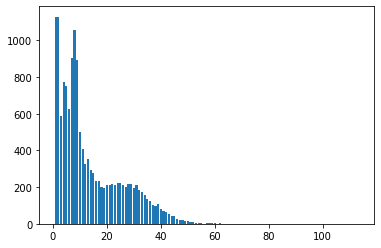

In [27]:
plt.bar(list(map(lambda x: x[0], train_length_hist)),
        list(map(lambda x: x[1], train_length_hist)))

We create bins of sentences of the same length. This is to avoid padding

In [28]:
training_bins = []
for bin in train_length_hist:
    training_bins += [training_set_sorted[:bin[1]]]
    training_set_sorted = training_set_sorted[bin[1]:]

## Training the Model

We now create a generator to generate batches of sentences with the same length

In [29]:
def minibatch_generator(dataset):
    # We take the sentences of the same length
    for sentence_bin in dataset:
        # The number of batches. 
        batch_cnt = int(np.ceil((len(sentence_bin) / BATCH_SIZE)))
        # We create batches of BATCH_SIZE
        for j in range(batch_cnt):
            char_batch = []
            token_batch = []
            label_batch = []
            for sentence in sentence_bin[j*BATCH_SIZE:(j+1)*BATCH_SIZE]:
                tokens, chars, labels = sentence
                char_batch.append(chars)
                token_batch.append(tokens)
                label_batch.append(labels)
            label_batch = list(map(lambda x: np.transpose([x]), label_batch))
            label_batch = to_categorical(label_batch, num_classes=len(ner))
            yield  np.asarray(char_batch), np.asarray(token_batch), label_batch

In [30]:
model.metrics_names

['loss', 'crf_viterbi_accuracy']

In [31]:
def predict(X_char_idx, X_word_idx, model, idx2pos, default_tag='O'):
    """
    Function to predict the test set and converts the indices to symbols
    """

    Y_pred_vect = []
    for x_char, x_word in zip(X_char_idx, X_word_idx):
        y_pred_vect = model.predict([np.array([x_char]),
                                          np.array([x_word])])[0]
        Y_pred_vect += [y_pred_vect]

    # print('Y_test_pred_vect', Y_test_pred_vect[:2])
    # Convert to POS or NER idx to symbols
    Y_pred = []
    for y_pred_vect in Y_pred_vect:
        pos_idx = np.argmax(y_pred_vect, axis=-1)
        # print('POS_IDX', pos_idx)
        # We convert the indices into symbols
        # If the symbol does not exist, we tag the word with O, the default tag
        pos_cat = list(map(lambda x: idx2pos.get(x, default_tag), pos_idx))
        # We add a sanity check if the classifier has predicted a nonvalid tag.
        # This could only be the padding index: 0
        for pos in pos_idx:
            if pos not in idx2pos:
                print('Bad, should not occur:', pos)
                print((-y_pred_vect).argsort())
                print('Bad, should not occur:', y_pred_vect)
        Y_pred += [pos_cat]
    return Y_pred

With the next function, we format the words, the named entity tags, and the predicted named entity tags so that we can evaluate them. It necessary converts them to the IOBES tagset.

In [32]:
def format_conll(X_words, Y, Y_hat):
    total_words = 0
    correct = 0
    total_ukn = 0
    correct_ukn = 0
    conll_pred_corpus = ''
    
    for sent_nbr, y_vect_hat in enumerate(Y_hat):
        for word_nbr, y_hat in enumerate(y_vect_hat):
            unknown_word = False
            # y is the correct named entity tag
            y = Y[sent_nbr][word_nbr]
            if ANNOTATION == 'IOBES':
                if y[0] == 'S':
                    y = 'B' + y[1:]
                if y[0] == 'E':
                    y = 'I' + y[1:]
                if y_hat[0] == 'S':
                    y_hat = 'B' + y_hat[1:]
                if y_hat[0] == 'E':
                    y_hat = 'I' + y_hat[1:]
            line = ' '.join([X_words[sent_nbr][word_nbr],
                                     y, y_hat])
            line += '\n'
            total_words += 1
            conll_pred_corpus += line
            #file.write(line)
            # The word is not in the dictionary
            if X_words[sent_nbr][word_nbr] not in word2idx:
                total_ukn += 1
                unknown_word = True
            if y_hat == y:
                correct += 1
                if unknown_word:
                    correct_ukn += 1
        conll_pred_corpus += '\n'
        #file.write('\n')
    print('total %d, correct %d, accuracy %f' % (total_words, correct, correct / total_words))
    if total_ukn != 0:
        print('total unknown %d, correct %d, accuracy %f' % (total_ukn, correct_ukn, correct_ukn / total_ukn))
    return conll_pred_corpus

In [33]:
for epoch in range(EPOCHS):    
    print("Epoch {}/{}".format(epoch + 1, EPOCHS))
    for i, batch in tqdm(enumerate(minibatch_generator(training_bins))):
        char_batch, token_batch, label_batch = batch  
        loss = model.train_on_batch([char_batch, token_batch], 
                                    label_batch)

    # We evaluate the dev set
    print('CoNLL score dev set')
    Y_dev_hat = predict(X_dev_char_idx, X_dev_word_idx, model, idx2ner)
    conll_dev_pred = format_conll(X_dev_word_cat, Y_dev_cat, Y_dev_hat)
    
    signature = '_' + str(CHAR_DROPOUT) + '_' + str(DROPOUT_RATE_PRE) + '_' +\
    str(RECURRENT_DROPOUT) + '_' + str(DROPOUT_RATE) + '_' + str(DROPOUT_RATE_POST) + '_'
    
    outfile = 'results/' + 'dev' + signature + '.out'
    with open(outfile, 'w') as file:
        file.write(conll_dev_pred)
    print(os.popen('perl -w conlleval.pl <' + outfile).read())
    
    # We evaluate the test set
    print('CoNLL score test set')
    Y_test_hat = predict(X_test_char_idx, X_test_word_idx, model, idx2ner)
    conll_test_pred = format_conll(X_test_word_cat, Y_test_cat, Y_test_hat)
    
    outfile = 'results/' + 'test' + signature + '.out'
    with open(outfile, 'w') as file:
        file.write(conll_test_pred)
    print(os.popen('perl -w conlleval.pl <' + outfile).read())

0it [00:00, ?it/s]

Epoch 1/80


/Users/pierre/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
76it [00:39,  1.90it/s]


CoNLL score dev set
total 51578, correct 43887, accuracy 0.850886
total unknown 713, correct 509, accuracy 0.713885
processed 51578 tokens with 5942 phrases; found: 1322 phrases; correct: 669.
accuracy:  85.09%; precision:  50.61%; recall:  11.26%; FB1:  18.42
              LOC: precision:  81.63%; recall:  19.11%; FB1:  30.97  430
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  13
              ORG: precision:  70.52%; recall:   9.10%; FB1:  16.12  173
              PER: precision:  27.76%; recall:  10.64%; FB1:  15.38  706

CoNLL score test set
total 46666, correct 39473, accuracy 0.845862
total unknown 1143, correct 857, accuracy 0.749781


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 1416 phrases; correct: 635.
accuracy:  84.59%; precision:  44.84%; recall:  11.24%; FB1:  17.98
              LOC: precision:  69.25%; recall:  20.38%; FB1:  31.50  491
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  14
              ORG: precision:  38.63%; recall:   5.42%; FB1:   9.50  233
              PER: precision:  30.24%; recall:  12.68%; FB1:  17.86  678

Epoch 2/80


76it [00:37,  2.04it/s]


CoNLL score dev set
total 51578, correct 46176, accuracy 0.895265
total unknown 713, correct 548, accuracy 0.768583
processed 51578 tokens with 5942 phrases; found: 3101 phrases; correct: 2144.
accuracy:  89.53%; precision:  69.14%; recall:  36.08%; FB1:  47.42
              LOC: precision:  85.03%; recall:  45.45%; FB1:  59.24  982
             MISC: precision:  82.61%; recall:   6.18%; FB1:  11.50  69
              ORG: precision:  64.96%; recall:  25.58%; FB1:  36.70  528
              PER: precision:  59.72%; recall:  49.35%; FB1:  54.04  1522

CoNLL score test set
total 46666, correct 41559, accuracy 0.890563
total unknown 1143, correct 911, accuracy 0.797025


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 3099 phrases; correct: 2021.
accuracy:  89.06%; precision:  65.21%; recall:  35.78%; FB1:  46.21
              LOC: precision:  77.36%; recall:  44.66%; FB1:  56.63  963
             MISC: precision:  70.83%; recall:   4.84%; FB1:   9.07  48
              ORG: precision:  54.40%; recall:  26.79%; FB1:  35.90  818
              PER: precision:  62.76%; recall:  49.29%; FB1:  55.21  1270

Epoch 3/80


76it [00:37,  2.05it/s]


CoNLL score dev set
total 51578, correct 47929, accuracy 0.929253
total unknown 713, correct 607, accuracy 0.851332
processed 51578 tokens with 5942 phrases; found: 4796 phrases; correct: 3639.
accuracy:  92.93%; precision:  75.88%; recall:  61.24%; FB1:  67.78
              LOC: precision:  81.56%; recall:  71.53%; FB1:  76.22  1611
             MISC: precision:  82.21%; recall:  29.07%; FB1:  42.95  326
              ORG: precision:  56.51%; recall:  47.58%; FB1:  51.66  1129
              PER: precision:  82.02%; recall:  77.04%; FB1:  79.45  1730

CoNLL score test set
total 46666, correct 43033, accuracy 0.922149
total unknown 1143, correct 983, accuracy 0.860017


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 4841 phrases; correct: 3289.
accuracy:  92.21%; precision:  67.94%; recall:  58.23%; FB1:  62.71
              LOC: precision:  73.39%; recall:  70.92%; FB1:  72.13  1612
             MISC: precision:  78.21%; recall:  28.63%; FB1:  41.92  257
              ORG: precision:  49.27%; recall:  44.79%; FB1:  46.93  1510
              PER: precision:  79.41%; recall:  71.80%; FB1:  75.41  1462

Epoch 4/80


76it [00:37,  2.04it/s]


CoNLL score dev set
total 51578, correct 48798, accuracy 0.946101
total unknown 713, correct 627, accuracy 0.879383
processed 51578 tokens with 5942 phrases; found: 5424 phrases; correct: 4299.
accuracy:  94.61%; precision:  79.26%; recall:  72.35%; FB1:  75.65
              LOC: precision:  84.26%; recall:  83.94%; FB1:  84.10  1830
             MISC: precision:  83.67%; recall:  44.47%; FB1:  58.07  490
              ORG: precision:  64.40%; recall:  57.87%; FB1:  60.96  1205
              PER: precision:  82.73%; recall:  85.29%; FB1:  83.99  1899

CoNLL score test set
total 46666, correct 43885, accuracy 0.940406
total unknown 1143, correct 1006, accuracy 0.880140


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5452 phrases; correct: 3966.
accuracy:  94.04%; precision:  72.74%; recall:  70.22%; FB1:  71.46
              LOC: precision:  78.12%; recall:  82.61%; FB1:  80.30  1764
             MISC: precision:  74.04%; recall:  43.87%; FB1:  55.10  416
              ORG: precision:  58.38%; recall:  58.28%; FB1:  58.33  1658
              PER: precision:  81.29%; recall:  81.14%; FB1:  81.21  1614

Epoch 5/80


76it [00:37,  2.02it/s]


CoNLL score dev set
total 51578, correct 49065, accuracy 0.951278
total unknown 713, correct 627, accuracy 0.879383
processed 51578 tokens with 5942 phrases; found: 5328 phrases; correct: 4375.
accuracy:  95.13%; precision:  82.11%; recall:  73.63%; FB1:  77.64
              LOC: precision:  89.24%; recall:  81.27%; FB1:  85.07  1673
             MISC: precision:  83.19%; recall:  52.06%; FB1:  64.04  577
              ORG: precision:  65.03%; recall:  63.09%; FB1:  64.04  1301
              PER: precision:  87.56%; recall:  84.47%; FB1:  85.99  1777

CoNLL score test set
total 46666, correct 44041, accuracy 0.943749
total unknown 1143, correct 1001, accuracy 0.875766


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5260 phrases; correct: 3982.
accuracy:  94.37%; precision:  75.70%; recall:  70.50%; FB1:  73.01
              LOC: precision:  83.93%; recall:  78.60%; FB1:  81.18  1562
             MISC: precision:  71.81%; recall:  49.72%; FB1:  58.75  486
              ORG: precision:  61.66%; recall:  63.52%; FB1:  62.57  1711
              PER: precision:  84.41%; recall:  78.35%; FB1:  81.27  1501

Epoch 6/80


76it [00:37,  2.02it/s]


CoNLL score dev set
total 51578, correct 49733, accuracy 0.964229
total unknown 713, correct 636, accuracy 0.892006
processed 51578 tokens with 5942 phrases; found: 5907 phrases; correct: 4886.
accuracy:  96.42%; precision:  82.72%; recall:  82.23%; FB1:  82.47
              LOC: precision:  89.57%; recall:  86.99%; FB1:  88.26  1784
             MISC: precision:  84.12%; recall:  62.04%; FB1:  71.41  680
              ORG: precision:  65.66%; recall:  75.99%; FB1:  70.45  1552
              PER: precision:  89.74%; recall:  92.13%; FB1:  90.92  1891

CoNLL score test set
total 46666, correct 44691, accuracy 0.957678
total unknown 1143, correct 1022, accuracy 0.894138


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5737 phrases; correct: 4547.
accuracy:  95.77%; precision:  79.26%; recall:  80.51%; FB1:  79.88
              LOC: precision:  85.24%; recall:  86.57%; FB1:  85.90  1694
             MISC: precision:  76.31%; recall:  58.26%; FB1:  66.07  536
              ORG: precision:  66.10%; recall:  76.64%; FB1:  70.98  1926
              PER: precision:  89.88%; recall:  87.88%; FB1:  88.87  1581

Epoch 7/80


76it [00:37,  2.03it/s]


CoNLL score dev set
total 51578, correct 49933, accuracy 0.968107
total unknown 713, correct 650, accuracy 0.911641
processed 51578 tokens with 5942 phrases; found: 6043 phrases; correct: 5061.
accuracy:  96.81%; precision:  83.75%; recall:  85.17%; FB1:  84.46
              LOC: precision:  91.86%; recall:  88.51%; FB1:  90.16  1770
             MISC: precision:  85.43%; recall:  65.51%; FB1:  74.16  707
              ORG: precision:  69.17%; recall:  82.33%; FB1:  75.18  1596
              PER: precision:  87.66%; recall:  93.76%; FB1:  90.61  1970

CoNLL score test set
total 46666, correct 44791, accuracy 0.959821
total unknown 1143, correct 1020, accuracy 0.892388


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5814 phrases; correct: 4684.
accuracy:  95.98%; precision:  80.56%; recall:  82.93%; FB1:  81.73
              LOC: precision:  87.97%; recall:  87.23%; FB1:  87.60  1654
             MISC: precision:  78.26%; recall:  61.54%; FB1:  68.90  552
              ORG: precision:  69.01%; recall:  80.43%; FB1:  74.28  1936
              PER: precision:  87.38%; recall:  90.35%; FB1:  88.84  1672

Epoch 8/80


76it [00:37,  2.01it/s]


CoNLL score dev set
total 51578, correct 50096, accuracy 0.971267
total unknown 713, correct 653, accuracy 0.915849
processed 51578 tokens with 5942 phrases; found: 6199 phrases; correct: 5196.
accuracy:  97.13%; precision:  83.82%; recall:  87.45%; FB1:  85.59
              LOC: precision:  91.39%; recall:  90.69%; FB1:  91.04  1823
             MISC: precision:  86.43%; recall:  67.68%; FB1:  75.91  722
              ORG: precision:  68.35%; recall:  86.80%; FB1:  76.48  1703
              PER: precision:  89.29%; recall:  94.57%; FB1:  91.85  1951

CoNLL score test set
total 46666, correct 44902, accuracy 0.962199
total unknown 1143, correct 1027, accuracy 0.898513


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5959 phrases; correct: 4808.
accuracy:  96.22%; precision:  80.68%; recall:  85.13%; FB1:  82.85
              LOC: precision:  87.43%; recall:  89.21%; FB1:  88.31  1702
             MISC: precision:  76.68%; recall:  63.25%; FB1:  69.32  579
              ORG: precision:  68.41%; recall:  85.25%; FB1:  75.90  2070
              PER: precision:  90.80%; recall:  90.29%; FB1:  90.54  1608

Epoch 9/80


76it [00:38,  2.00it/s]


CoNLL score dev set
total 51578, correct 50099, accuracy 0.971325
total unknown 713, correct 651, accuracy 0.913043
processed 51578 tokens with 5942 phrases; found: 6156 phrases; correct: 5207.
accuracy:  97.13%; precision:  84.58%; recall:  87.63%; FB1:  86.08
              LOC: precision:  94.49%; recall:  89.60%; FB1:  91.98  1742
             MISC: precision:  87.33%; recall:  68.76%; FB1:  76.94  726
              ORG: precision:  68.49%; recall:  87.99%; FB1:  77.02  1723
              PER: precision:  88.91%; recall:  94.84%; FB1:  91.78  1965

CoNLL score test set
total 46666, correct 44934, accuracy 0.962885
total unknown 1143, correct 1029, accuracy 0.900262


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5936 phrases; correct: 4864.
accuracy:  96.29%; precision:  81.94%; recall:  86.12%; FB1:  83.98
              LOC: precision:  90.86%; recall:  88.85%; FB1:  89.85  1631
             MISC: precision:  79.41%; recall:  65.38%; FB1:  71.72  578
              ORG: precision:  69.71%; recall:  87.00%; FB1:  77.40  2073
              PER: precision:  89.36%; recall:  91.40%; FB1:  90.37  1654

Epoch 10/80


76it [00:37,  2.00it/s]


CoNLL score dev set
total 51578, correct 49881, accuracy 0.967098
total unknown 713, correct 653, accuracy 0.915849
processed 51578 tokens with 5942 phrases; found: 6233 phrases; correct: 5172.
accuracy:  96.71%; precision:  82.98%; recall:  87.04%; FB1:  84.96
              LOC: precision:  92.81%; recall:  89.98%; FB1:  91.38  1781
             MISC: precision:  88.54%; recall:  67.90%; FB1:  76.86  707
              ORG: precision:  64.38%; recall:  86.65%; FB1:  73.87  1805
              PER: precision:  89.23%; recall:  93.97%; FB1:  91.54  1940

CoNLL score test set
total 46666, correct 44605, accuracy 0.955835
total unknown 1143, correct 1022, accuracy 0.894138


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 6044 phrases; correct: 4778.
accuracy:  95.58%; precision:  79.05%; recall:  84.60%; FB1:  81.73
              LOC: precision:  89.22%; recall:  88.79%; FB1:  89.00  1660
             MISC: precision:  75.73%; recall:  62.68%; FB1:  68.59  581
              ORG: precision:  64.51%; recall:  85.91%; FB1:  73.69  2212
              PER: precision:  89.88%; recall:  88.44%; FB1:  89.15  1591

Epoch 11/80


76it [00:37,  2.00it/s]


CoNLL score dev set
total 51578, correct 50333, accuracy 0.975862
total unknown 713, correct 655, accuracy 0.918654
processed 51578 tokens with 5942 phrases; found: 6133 phrases; correct: 5349.
accuracy:  97.59%; precision:  87.22%; recall:  90.02%; FB1:  88.60
              LOC: precision:  93.29%; recall:  93.79%; FB1:  93.54  1847
             MISC: precision:  87.11%; recall:  75.49%; FB1:  80.88  799
              ORG: precision:  73.84%; recall:  89.26%; FB1:  80.82  1621
              PER: precision:  92.87%; recall:  94.08%; FB1:  93.47  1866

CoNLL score test set
total 46666, correct 45030, accuracy 0.964942
total unknown 1143, correct 1029, accuracy 0.900262


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5924 phrases; correct: 4895.
accuracy:  96.49%; precision:  82.63%; recall:  86.67%; FB1:  84.60
              LOC: precision:  89.42%; recall:  91.25%; FB1:  90.33  1702
             MISC: precision:  72.67%; recall:  67.81%; FB1:  70.15  655
              ORG: precision:  72.28%; recall:  87.60%; FB1:  79.21  2013
              PER: precision:  92.79%; recall:  89.18%; FB1:  90.95  1554

Epoch 12/80


76it [00:37,  2.00it/s]


CoNLL score dev set
total 51578, correct 50487, accuracy 0.978848
total unknown 713, correct 649, accuracy 0.910238
processed 51578 tokens with 5942 phrases; found: 5985 phrases; correct: 5309.
accuracy:  97.88%; precision:  88.71%; recall:  89.35%; FB1:  89.02
              LOC: precision:  95.86%; recall:  89.44%; FB1:  92.54  1714
             MISC: precision:  91.28%; recall:  77.22%; FB1:  83.67  780
              ORG: precision:  78.19%; recall:  88.74%; FB1:  83.13  1522
              PER: precision:  89.59%; recall:  95.77%; FB1:  92.57  1969

CoNLL score test set
total 46666, correct 45365, accuracy 0.972121
total unknown 1143, correct 1038, accuracy 0.908136


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5737 phrases; correct: 4944.
accuracy:  97.21%; precision:  86.18%; recall:  87.54%; FB1:  86.85
              LOC: precision:  93.02%; recall:  88.73%; FB1:  90.83  1591
             MISC: precision:  78.40%; recall:  71.37%; FB1:  74.72  639
              ORG: precision:  79.33%; recall:  87.12%; FB1:  83.04  1824
              PER: precision:  90.08%; recall:  93.75%; FB1:  91.88  1683

Epoch 13/80


76it [00:37,  2.01it/s]


CoNLL score dev set
total 51578, correct 50391, accuracy 0.976986
total unknown 713, correct 655, accuracy 0.918654
processed 51578 tokens with 5942 phrases; found: 6045 phrases; correct: 5354.
accuracy:  97.70%; precision:  88.57%; recall:  90.10%; FB1:  89.33
              LOC: precision:  96.01%; recall:  93.03%; FB1:  94.50  1780
             MISC: precision:  90.59%; recall:  75.16%; FB1:  82.16  765
              ORG: precision:  74.71%; recall:  90.31%; FB1:  81.77  1621
              PER: precision:  92.66%; recall:  94.52%; FB1:  93.58  1879

CoNLL score test set
total 46666, correct 45145, accuracy 0.967407
total unknown 1143, correct 1033, accuracy 0.903762


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5831 phrases; correct: 4923.
accuracy:  96.74%; precision:  84.43%; recall:  87.16%; FB1:  85.77
              LOC: precision:  91.83%; recall:  90.95%; FB1:  91.39  1652
             MISC: precision:  77.39%; recall:  66.81%; FB1:  71.71  606
              ORG: precision:  73.85%; recall:  88.92%; FB1:  80.69  2000
              PER: precision:  92.82%; recall:  90.29%; FB1:  91.54  1573

Epoch 14/80


76it [00:38,  1.99it/s]


CoNLL score dev set
total 51578, correct 50460, accuracy 0.978324
total unknown 713, correct 660, accuracy 0.925666
processed 51578 tokens with 5942 phrases; found: 6049 phrases; correct: 5374.
accuracy:  97.83%; precision:  88.84%; recall:  90.44%; FB1:  89.63
              LOC: precision:  95.27%; recall:  94.34%; FB1:  94.80  1819
             MISC: precision:  90.09%; recall:  72.99%; FB1:  80.65  747
              ORG: precision:  76.38%; recall:  90.68%; FB1:  82.92  1592
              PER: precision:  92.65%; recall:  95.11%; FB1:  93.87  1891

CoNLL score test set
total 46666, correct 45240, accuracy 0.969442
total unknown 1143, correct 1039, accuracy 0.909011


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5822 phrases; correct: 4964.
accuracy:  96.94%; precision:  85.26%; recall:  87.89%; FB1:  86.56
              LOC: precision:  90.76%; recall:  92.51%; FB1:  91.63  1700
             MISC: precision:  79.25%; recall:  66.38%; FB1:  72.25  588
              ORG: precision:  76.00%; recall:  89.04%; FB1:  82.01  1946
              PER: precision:  92.95%; recall:  91.28%; FB1:  92.11  1588

Epoch 15/80


76it [00:37,  2.02it/s]


CoNLL score dev set
total 51578, correct 50407, accuracy 0.977297
total unknown 713, correct 657, accuracy 0.921459
processed 51578 tokens with 5942 phrases; found: 5998 phrases; correct: 5339.
accuracy:  97.73%; precision:  89.01%; recall:  89.85%; FB1:  89.43
              LOC: precision:  97.07%; recall:  92.11%; FB1:  94.53  1743
             MISC: precision:  90.08%; recall:  76.79%; FB1:  82.90  786
              ORG: precision:  75.03%; recall:  89.86%; FB1:  81.78  1606
              PER: precision:  93.08%; recall:  94.14%; FB1:  93.60  1863

CoNLL score test set
total 46666, correct 45165, accuracy 0.967835
total unknown 1143, correct 1040, accuracy 0.909886


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5811 phrases; correct: 4930.
accuracy:  96.78%; precision:  84.84%; recall:  87.29%; FB1:  86.05
              LOC: precision:  93.38%; recall:  89.57%; FB1:  91.43  1600
             MISC: precision:  76.87%; recall:  68.66%; FB1:  72.54  627
              ORG: precision:  73.70%; recall:  89.58%; FB1:  80.87  2019
              PER: precision:  93.67%; recall:  90.66%; FB1:  92.14  1565

Epoch 16/80


76it [00:37,  2.02it/s]


CoNLL score dev set
total 51578, correct 50572, accuracy 0.980496
total unknown 713, correct 661, accuracy 0.927069
processed 51578 tokens with 5942 phrases; found: 5915 phrases; correct: 5383.
accuracy:  98.05%; precision:  91.01%; recall:  90.59%; FB1:  90.80
              LOC: precision:  96.60%; recall:  94.45%; FB1:  95.51  1796
             MISC: precision:  91.85%; recall:  77.01%; FB1:  83.78  773
              ORG: precision:  80.36%; recall:  88.81%; FB1:  84.38  1482
              PER: precision:  93.72%; recall:  94.84%; FB1:  94.28  1864

CoNLL score test set
total 46666, correct 45301, accuracy 0.970750
total unknown 1143, correct 1040, accuracy 0.909886


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5692 phrases; correct: 4925.
accuracy:  97.07%; precision:  86.52%; recall:  87.20%; FB1:  86.86
              LOC: precision:  91.75%; recall:  91.37%; FB1:  91.56  1661
             MISC: precision:  78.49%; recall:  66.52%; FB1:  72.01  595
              ORG: precision:  78.33%; recall:  87.48%; FB1:  82.65  1855
              PER: precision:  93.67%; recall:  91.59%; FB1:  92.62  1581

Epoch 17/80


76it [00:37,  2.00it/s]


CoNLL score dev set
total 51578, correct 50558, accuracy 0.980224
total unknown 713, correct 656, accuracy 0.920056
processed 51578 tokens with 5942 phrases; found: 5992 phrases; correct: 5369.
accuracy:  98.02%; precision:  89.60%; recall:  90.36%; FB1:  89.98
              LOC: precision:  96.62%; recall:  93.25%; FB1:  94.90  1773
             MISC: precision:  92.72%; recall:  74.62%; FB1:  82.69  742
              ORG: precision:  76.49%; recall:  90.98%; FB1:  83.11  1595
              PER: precision:  92.88%; recall:  94.90%; FB1:  93.88  1882

CoNLL score test set
total 46666, correct 45341, accuracy 0.971607
total unknown 1143, correct 1044, accuracy 0.913386


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5752 phrases; correct: 4952.
accuracy:  97.16%; precision:  86.09%; recall:  87.68%; FB1:  86.88
              LOC: precision:  92.94%; recall:  90.71%; FB1:  91.81  1628
             MISC: precision:  79.79%; recall:  65.81%; FB1:  72.13  579
              ORG: precision:  76.55%; recall:  90.19%; FB1:  82.81  1957
              PER: precision:  93.14%; recall:  91.47%; FB1:  92.29  1588

Epoch 18/80


76it [00:37,  2.00it/s]


CoNLL score dev set
total 51578, correct 50623, accuracy 0.981484
total unknown 713, correct 664, accuracy 0.931276
processed 51578 tokens with 5942 phrases; found: 5977 phrases; correct: 5415.
accuracy:  98.15%; precision:  90.60%; recall:  91.13%; FB1:  90.86
              LOC: precision:  97.18%; recall:  93.85%; FB1:  95.49  1774
             MISC: precision:  92.36%; recall:  76.03%; FB1:  83.40  759
              ORG: precision:  78.77%; recall:  91.05%; FB1:  84.47  1550
              PER: precision:  93.40%; recall:  96.04%; FB1:  94.70  1894

CoNLL score test set
total 46666, correct 45441, accuracy 0.973750
total unknown 1143, correct 1046, accuracy 0.915136


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5738 phrases; correct: 4997.
accuracy:  97.37%; precision:  87.09%; recall:  88.47%; FB1:  87.77
              LOC: precision:  93.23%; recall:  91.61%; FB1:  92.41  1639
             MISC: precision:  80.62%; recall:  66.95%; FB1:  73.15  583
              ORG: precision:  78.67%; recall:  89.95%; FB1:  83.93  1899
              PER: precision:  93.07%; recall:  93.07%; FB1:  93.07  1617

Epoch 19/80


76it [00:37,  2.01it/s]


CoNLL score dev set
total 51578, correct 50747, accuracy 0.983888
total unknown 713, correct 667, accuracy 0.935484
processed 51578 tokens with 5942 phrases; found: 6007 phrases; correct: 5485.
accuracy:  98.39%; precision:  91.31%; recall:  92.31%; FB1:  91.81
              LOC: precision:  95.96%; recall:  95.59%; FB1:  95.77  1830
             MISC: precision:  91.83%; recall:  79.28%; FB1:  85.10  796
              ORG: precision:  81.09%; recall:  91.80%; FB1:  86.11  1518
              PER: precision:  94.85%; recall:  95.93%; FB1:  95.38  1863

CoNLL score test set
total 46666, correct 45510, accuracy 0.975228
total unknown 1143, correct 1051, accuracy 0.919510


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5766 phrases; correct: 5024.
accuracy:  97.52%; precision:  87.13%; recall:  88.95%; FB1:  88.03
              LOC: precision:  91.34%; recall:  92.33%; FB1:  91.83  1686
             MISC: precision:  79.07%; recall:  70.51%; FB1:  74.55  626
              ORG: precision:  79.56%; recall:  90.25%; FB1:  84.57  1884
              PER: precision:  94.90%; recall:  92.15%; FB1:  93.50  1570

Epoch 20/80


76it [00:37,  2.05it/s]


CoNLL score dev set
total 51578, correct 50758, accuracy 0.984102
total unknown 713, correct 674, accuracy 0.945302
processed 51578 tokens with 5942 phrases; found: 5997 phrases; correct: 5500.
accuracy:  98.41%; precision:  91.71%; recall:  92.56%; FB1:  92.14
              LOC: precision:  96.52%; recall:  95.16%; FB1:  95.83  1811
             MISC: precision:  92.34%; recall:  81.02%; FB1:  86.31  809
              ORG: precision:  83.95%; recall:  91.28%; FB1:  87.46  1458
              PER: precision:  92.81%; recall:  96.69%; FB1:  94.71  1919

CoNLL score test set
total 46666, correct 45525, accuracy 0.975550
total unknown 1143, correct 1054, accuracy 0.922135


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5749 phrases; correct: 5039.
accuracy:  97.55%; precision:  87.65%; recall:  89.22%; FB1:  88.43
              LOC: precision:  92.41%; recall:  91.91%; FB1:  92.16  1659
             MISC: precision:  79.14%; recall:  70.80%; FB1:  74.74  628
              ORG: precision:  81.59%; recall:  89.64%; FB1:  85.43  1825
              PER: precision:  92.85%; recall:  94.00%; FB1:  93.42  1637

Epoch 21/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50780, accuracy 0.984528
total unknown 713, correct 676, accuracy 0.948107
processed 51578 tokens with 5942 phrases; found: 5957 phrases; correct: 5495.
accuracy:  98.45%; precision:  92.24%; recall:  92.48%; FB1:  92.36
              LOC: precision:  95.76%; recall:  95.92%; FB1:  95.84  1840
             MISC: precision:  90.05%; recall:  82.43%; FB1:  86.07  844
              ORG: precision:  84.48%; recall:  90.53%; FB1:  87.40  1437
              PER: precision:  95.81%; recall:  95.49%; FB1:  95.65  1836

CoNLL score test set
total 46666, correct 45426, accuracy 0.973428
total unknown 1143, correct 1053, accuracy 0.921260


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5736 phrases; correct: 5020.
accuracy:  97.34%; precision:  87.52%; recall:  88.88%; FB1:  88.19
              LOC: precision:  91.05%; recall:  92.75%; FB1:  91.89  1699
             MISC: precision:  78.13%; recall:  73.79%; FB1:  75.90  663
              ORG: precision:  80.48%; recall:  88.86%; FB1:  84.46  1834
              PER: precision:  96.04%; recall:  91.47%; FB1:  93.70  1540

Epoch 22/80


76it [00:34,  2.22it/s]


CoNLL score dev set
total 51578, correct 50816, accuracy 0.985226
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 5915 phrases; correct: 5496.
accuracy:  98.52%; precision:  92.92%; recall:  92.49%; FB1:  92.70
              LOC: precision:  95.76%; recall:  95.81%; FB1:  95.78  1838
             MISC: precision:  93.33%; recall:  81.89%; FB1:  87.23  809
              ORG: precision:  87.18%; recall:  89.26%; FB1:  88.21  1373
              PER: precision:  94.14%; recall:  96.85%; FB1:  95.48  1895

CoNLL score test set
total 46666, correct 45619, accuracy 0.977564
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5642 phrases; correct: 5065.
accuracy:  97.76%; precision:  89.77%; recall:  89.68%; FB1:  89.73
              LOC: precision:  91.02%; recall:  93.59%; FB1:  92.28  1715
             MISC: precision:  82.94%; recall:  74.79%; FB1:  78.65  633
              ORG: precision:  87.24%; recall:  86.82%; FB1:  87.02  1653
              PER: precision:  93.66%; recall:  95.05%; FB1:  94.35  1641

Epoch 23/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 50795, accuracy 0.984819
total unknown 713, correct 676, accuracy 0.948107
processed 51578 tokens with 5942 phrases; found: 5967 phrases; correct: 5508.
accuracy:  98.48%; precision:  92.31%; recall:  92.70%; FB1:  92.50
              LOC: precision:  97.70%; recall:  94.61%; FB1:  96.13  1779
             MISC: precision:  90.11%; recall:  82.97%; FB1:  86.39  849
              ORG: precision:  85.45%; recall:  90.68%; FB1:  87.99  1423
              PER: precision:  93.37%; recall:  97.12%; FB1:  95.21  1916

CoNLL score test set
total 46666, correct 45576, accuracy 0.976643
total unknown 1143, correct 1062, accuracy 0.929134


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5711 phrases; correct: 5075.
accuracy:  97.66%; precision:  88.86%; recall:  89.85%; FB1:  89.36
              LOC: precision:  93.51%; recall:  91.55%; FB1:  92.52  1633
             MISC: precision:  78.65%; recall:  76.07%; FB1:  77.34  679
              ORG: precision:  84.71%; recall:  89.04%; FB1:  86.82  1746
              PER: precision:  92.86%; recall:  94.93%; FB1:  93.88  1653

Epoch 24/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50883, accuracy 0.986525
total unknown 713, correct 675, accuracy 0.946704
processed 51578 tokens with 5942 phrases; found: 5959 phrases; correct: 5525.
accuracy:  98.65%; precision:  92.72%; recall:  92.98%; FB1:  92.85
              LOC: precision:  96.24%; recall:  96.03%; FB1:  96.13  1833
             MISC: precision:  91.76%; recall:  80.91%; FB1:  85.99  813
              ORG: precision:  84.70%; recall:  93.29%; FB1:  88.79  1477
              PER: precision:  96.08%; recall:  95.77%; FB1:  95.92  1836

CoNLL score test set
total 46666, correct 45630, accuracy 0.977800
total unknown 1143, correct 1059, accuracy 0.926509


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5697 phrases; correct: 5068.
accuracy:  97.78%; precision:  88.96%; recall:  89.73%; FB1:  89.34
              LOC: precision:  91.53%; recall:  93.29%; FB1:  92.40  1700
             MISC: precision:  81.53%; recall:  72.93%; FB1:  76.99  628
              ORG: precision:  82.46%; recall:  90.55%; FB1:  86.31  1824
              PER: precision:  96.83%; recall:  92.52%; FB1:  94.62  1545

Epoch 25/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50843, accuracy 0.985750
total unknown 713, correct 677, accuracy 0.949509
processed 51578 tokens with 5942 phrases; found: 5938 phrases; correct: 5514.
accuracy:  98.57%; precision:  92.86%; recall:  92.80%; FB1:  92.83
              LOC: precision:  96.80%; recall:  95.48%; FB1:  96.14  1812
             MISC: precision:  91.87%; recall:  82.10%; FB1:  86.71  824
              ORG: precision:  84.75%; recall:  91.57%; FB1:  88.03  1449
              PER: precision:  95.79%; recall:  96.36%; FB1:  96.08  1853

CoNLL score test set
total 46666, correct 45564, accuracy 0.976385
total unknown 1143, correct 1061, accuracy 0.928259


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5693 phrases; correct: 5058.
accuracy:  97.64%; precision:  88.85%; recall:  89.55%; FB1:  89.20
              LOC: precision:  92.40%; recall:  91.85%; FB1:  92.12  1658
             MISC: precision:  80.31%; recall:  74.36%; FB1:  77.22  650
              ORG: precision:  82.70%; recall:  89.52%; FB1:  85.98  1798
              PER: precision:  95.59%; recall:  93.82%; FB1:  94.69  1587

Epoch 26/80


76it [00:35,  2.17it/s]


CoNLL score dev set
total 51578, correct 50917, accuracy 0.987184
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5956 phrases; correct: 5559.
accuracy:  98.72%; precision:  93.33%; recall:  93.55%; FB1:  93.44
              LOC: precision:  95.94%; recall:  96.57%; FB1:  96.26  1849
             MISC: precision:  90.01%; recall:  85.03%; FB1:  87.45  871
              ORG: precision:  88.22%; recall:  91.57%; FB1:  89.86  1392
              PER: precision:  96.15%; recall:  96.25%; FB1:  96.20  1844

CoNLL score test set
total 46666, correct 45640, accuracy 0.978014
total unknown 1143, correct 1069, accuracy 0.935258


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5690 phrases; correct: 5100.
accuracy:  97.80%; precision:  89.63%; recall:  90.30%; FB1:  89.96
              LOC: precision:  90.75%; recall:  93.53%; FB1:  92.12  1719
             MISC: precision:  79.45%; recall:  78.21%; FB1:  78.82  691
              ORG: precision:  86.39%; recall:  89.04%; FB1:  87.70  1712
              PER: precision:  96.43%; recall:  93.51%; FB1:  94.95  1568

Epoch 27/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 50881, accuracy 0.986486
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5930 phrases; correct: 5543.
accuracy:  98.65%; precision:  93.47%; recall:  93.29%; FB1:  93.38
              LOC: precision:  97.44%; recall:  95.48%; FB1:  96.45  1800
             MISC: precision:  91.38%; recall:  83.95%; FB1:  87.51  847
              ORG: precision:  87.33%; recall:  91.50%; FB1:  89.37  1405
              PER: precision:  95.21%; recall:  97.07%; FB1:  96.13  1878

CoNLL score test set
total 46666, correct 45641, accuracy 0.978035
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5674 phrases; correct: 5097.
accuracy:  97.80%; precision:  89.83%; recall:  90.24%; FB1:  90.04
              LOC: precision:  93.10%; recall:  92.27%; FB1:  92.68  1653
             MISC: precision:  80.80%; recall:  74.93%; FB1:  77.75  651
              ORG: precision:  85.33%; recall:  89.64%; FB1:  87.43  1745
              PER: precision:  94.95%; recall:  95.42%; FB1:  95.19  1625

Epoch 28/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 50948, accuracy 0.987785
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5576.
accuracy:  98.78%; precision:  94.06%; recall:  93.84%; FB1:  93.95
              LOC: precision:  97.77%; recall:  95.54%; FB1:  96.64  1795
             MISC: precision:  91.12%; recall:  86.77%; FB1:  88.89  878
              ORG: precision:  89.68%; recall:  92.02%; FB1:  90.84  1376
              PER: precision:  95.10%; recall:  97.01%; FB1:  96.05  1879

CoNLL score test set
total 46666, correct 45692, accuracy 0.979128
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5665 phrases; correct: 5116.
accuracy:  97.91%; precision:  90.31%; recall:  90.58%; FB1:  90.44
              LOC: precision:  93.37%; recall:  92.09%; FB1:  92.73  1645
             MISC: precision:  78.96%; recall:  80.20%; FB1:  79.58  713
              ORG: precision:  87.60%; recall:  88.86%; FB1:  88.22  1685
              PER: precision:  95.01%; recall:  95.30%; FB1:  95.15  1622

Epoch 29/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 50863, accuracy 0.986138
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 5906 phrases; correct: 5504.
accuracy:  98.61%; precision:  93.19%; recall:  92.63%; FB1:  92.91
              LOC: precision:  98.67%; recall:  92.71%; FB1:  95.59  1726
             MISC: precision:  89.43%; recall:  87.20%; FB1:  88.30  899
              ORG: precision:  85.42%; recall:  92.62%; FB1:  88.87  1454
              PER: precision:  96.06%; recall:  95.28%; FB1:  95.67  1827

CoNLL score test set
total 46666, correct 45565, accuracy 0.976407
total unknown 1143, correct 1059, accuracy 0.926509


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5652 phrases; correct: 5028.
accuracy:  97.64%; precision:  88.96%; recall:  89.02%; FB1:  88.99
              LOC: precision:  95.24%; recall:  89.87%; FB1:  92.47  1574
             MISC: precision:  76.76%; recall:  79.06%; FB1:  77.89  723
              ORG: precision:  81.94%; recall:  90.43%; FB1:  85.98  1833
              PER: precision:  96.71%; recall:  91.03%; FB1:  93.79  1522

Epoch 30/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 50970, accuracy 0.988212
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5956 phrases; correct: 5585.
accuracy:  98.82%; precision:  93.77%; recall:  93.99%; FB1:  93.88
              LOC: precision:  97.39%; recall:  95.48%; FB1:  96.43  1801
             MISC: precision:  90.69%; recall:  86.66%; FB1:  88.63  881
              ORG: precision:  89.55%; recall:  92.62%; FB1:  91.06  1387
              PER: precision:  94.86%; recall:  97.18%; FB1:  96.00  1887

CoNLL score test set
total 46666, correct 45707, accuracy 0.979450
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5695 phrases; correct: 5129.
accuracy:  97.94%; precision:  90.06%; recall:  90.81%; FB1:  90.43
              LOC: precision:  93.18%; recall:  92.63%; FB1:  92.90  1658
             MISC: precision:  79.15%; recall:  76.78%; FB1:  77.95  681
              ORG: precision:  86.95%; recall:  90.25%; FB1:  88.57  1724
              PER: precision:  94.73%; recall:  95.61%; FB1:  95.17  1632

Epoch 31/80


76it [00:35,  2.11it/s]


CoNLL score dev set
total 51578, correct 50930, accuracy 0.987437
total unknown 713, correct 679, accuracy 0.952314
processed 51578 tokens with 5942 phrases; found: 5940 phrases; correct: 5566.
accuracy:  98.74%; precision:  93.70%; recall:  93.67%; FB1:  93.69
              LOC: precision:  96.88%; recall:  96.24%; FB1:  96.56  1825
             MISC: precision:  90.15%; recall:  87.31%; FB1:  88.71  893
              ORG: precision:  88.24%; recall:  91.72%; FB1:  89.95  1394
              PER: precision:  96.44%; recall:  95.71%; FB1:  96.08  1828

CoNLL score test set
total 46666, correct 45583, accuracy 0.976793
total unknown 1143, correct 1066, accuracy 0.932633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5700 phrases; correct: 5078.
accuracy:  97.68%; precision:  89.09%; recall:  89.91%; FB1:  89.50
              LOC: precision:  91.69%; recall:  92.57%; FB1:  92.12  1684
             MISC: precision:  76.48%; recall:  79.20%; FB1:  77.82  727
              ORG: precision:  84.92%; recall:  89.16%; FB1:  86.99  1744
              PER: precision:  96.89%; recall:  92.58%; FB1:  94.69  1545

Epoch 32/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 50979, accuracy 0.988387
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5940 phrases; correct: 5587.
accuracy:  98.84%; precision:  94.06%; recall:  94.03%; FB1:  94.04
              LOC: precision:  97.03%; recall:  95.92%; FB1:  96.47  1816
             MISC: precision:  89.43%; recall:  89.05%; FB1:  89.24  918
              ORG: precision:  90.31%; recall:  92.47%; FB1:  91.38  1373
              PER: precision:  96.24%; recall:  95.77%; FB1:  96.00  1833

CoNLL score test set
total 46666, correct 45624, accuracy 0.977671
total unknown 1143, correct 1064, accuracy 0.930884


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5665 phrases; correct: 5082.
accuracy:  97.77%; precision:  89.71%; recall:  89.98%; FB1:  89.84
              LOC: precision:  92.77%; recall:  92.33%; FB1:  92.55  1660
             MISC: precision:  76.36%; recall:  80.06%; FB1:  78.16  736
              ORG: precision:  86.04%; recall:  89.40%; FB1:  87.69  1726
              PER: precision:  96.89%; recall:  92.46%; FB1:  94.62  1543

Epoch 33/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 50888, accuracy 0.986622
total unknown 713, correct 674, accuracy 0.945302
processed 51578 tokens with 5942 phrases; found: 5823 phrases; correct: 5504.
accuracy:  98.66%; precision:  94.52%; recall:  92.63%; FB1:  93.57
              LOC: precision:  97.54%; recall:  94.94%; FB1:  96.22  1788
             MISC: precision:  93.36%; recall:  85.36%; FB1:  89.18  843
              ORG: precision:  88.68%; recall:  90.53%; FB1:  89.59  1369
              PER: precision:  96.49%; recall:  95.49%; FB1:  95.99  1823

CoNLL score test set
total 46666, correct 45606, accuracy 0.977285
total unknown 1143, correct 1067, accuracy 0.933508


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5521 phrases; correct: 5025.
accuracy:  97.73%; precision:  91.02%; recall:  88.97%; FB1:  89.98
              LOC: precision:  93.76%; recall:  90.95%; FB1:  92.33  1618
             MISC: precision:  82.62%; recall:  77.21%; FB1:  79.82  656
              ORG: precision:  85.98%; recall:  87.48%; FB1:  86.72  1690
              PER: precision:  97.17%; recall:  93.57%; FB1:  95.34  1557

Epoch 34/80


76it [00:35,  2.13it/s]


CoNLL score dev set
total 51578, correct 50957, accuracy 0.987960
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5932 phrases; correct: 5562.
accuracy:  98.80%; precision:  93.76%; recall:  93.60%; FB1:  93.68
              LOC: precision:  97.13%; recall:  95.92%; FB1:  96.52  1814
             MISC: precision:  92.80%; recall:  83.84%; FB1:  88.09  833
              ORG: precision:  87.06%; recall:  92.84%; FB1:  89.86  1430
              PER: precision:  96.06%; recall:  96.74%; FB1:  96.40  1855

CoNLL score test set
total 46666, correct 45629, accuracy 0.977778
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5678 phrases; correct: 5080.
accuracy:  97.78%; precision:  89.47%; recall:  89.94%; FB1:  89.71
              LOC: precision:  93.03%; recall:  92.09%; FB1:  92.56  1651
             MISC: precision:  81.31%; recall:  72.51%; FB1:  76.66  626
              ORG: precision:  83.33%; recall:  90.91%; FB1:  86.96  1812
              PER: precision:  95.97%; recall:  94.31%; FB1:  95.13  1589

Epoch 35/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 50916, accuracy 0.987165
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5915 phrases; correct: 5555.
accuracy:  98.72%; precision:  93.91%; recall:  93.49%; FB1:  93.70
              LOC: precision:  96.01%; recall:  96.95%; FB1:  96.48  1855
             MISC: precision:  92.16%; recall:  85.47%; FB1:  88.69  855
              ORG: precision:  88.73%; recall:  90.45%; FB1:  89.59  1367
              PER: precision:  96.46%; recall:  96.25%; FB1:  96.36  1838

CoNLL score test set
total 46666, correct 45591, accuracy 0.976964
total unknown 1143, correct 1071, accuracy 0.937008


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5673 phrases; correct: 5079.
accuracy:  97.70%; precision:  89.53%; recall:  89.93%; FB1:  89.73
              LOC: precision:  90.50%; recall:  93.65%; FB1:  92.04  1726
             MISC: precision:  79.91%; recall:  76.50%; FB1:  78.17  672
              ORG: precision:  85.28%; recall:  88.26%; FB1:  86.75  1719
              PER: precision:  97.30%; recall:  93.63%; FB1:  95.43  1556

Epoch 36/80


76it [00:35,  2.14it/s]


CoNLL score dev set
total 51578, correct 50988, accuracy 0.988561
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5891 phrases; correct: 5581.
accuracy:  98.86%; precision:  94.74%; recall:  93.92%; FB1:  94.33
              LOC: precision:  96.77%; recall:  96.30%; FB1:  96.53  1828
             MISC: precision:  90.55%; recall:  87.31%; FB1:  88.90  889
              ORG: precision:  92.49%; recall:  91.80%; FB1:  92.14  1331
              PER: precision:  96.36%; recall:  96.42%; FB1:  96.39  1843

CoNLL score test set
total 46666, correct 45708, accuracy 0.979471
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5613 phrases; correct: 5098.
accuracy:  97.95%; precision:  90.82%; recall:  90.26%; FB1:  90.54
              LOC: precision:  91.60%; recall:  93.47%; FB1:  92.52  1702
             MISC: precision:  78.15%; recall:  80.48%; FB1:  79.30  723
              ORG: precision:  89.86%; recall:  87.48%; FB1:  88.65  1617
              PER: precision:  96.82%; recall:  94.06%; FB1:  95.42  1571

Epoch 37/80


76it [00:40,  1.89it/s]


CoNLL score dev set
total 51578, correct 50940, accuracy 0.987630
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5929 phrases; correct: 5563.
accuracy:  98.76%; precision:  93.83%; recall:  93.62%; FB1:  93.72
              LOC: precision:  95.26%; recall:  97.39%; FB1:  96.31  1878
             MISC: precision:  88.66%; recall:  88.18%; FB1:  88.42  917
              ORG: precision:  91.86%; recall:  89.26%; FB1:  90.54  1303
              PER: precision:  96.34%; recall:  95.77%; FB1:  96.05  1831

CoNLL score test set
total 46666, correct 45614, accuracy 0.977457
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5684 phrases; correct: 5077.
accuracy:  97.75%; precision:  89.32%; recall:  89.89%; FB1:  89.60
              LOC: precision:  88.03%; recall:  94.36%; FB1:  91.09  1788
             MISC: precision:  77.28%; recall:  80.91%; FB1:  79.05  735
              ORG: precision:  88.82%; recall:  85.61%; FB1:  87.19  1601
              PER: precision:  96.99%; recall:  93.57%; FB1:  95.25  1560

Epoch 38/80


76it [00:38,  1.98it/s]


CoNLL score dev set
total 51578, correct 50914, accuracy 0.987126
total unknown 713, correct 673, accuracy 0.943899
processed 51578 tokens with 5942 phrases; found: 5948 phrases; correct: 5541.
accuracy:  98.71%; precision:  93.16%; recall:  93.25%; FB1:  93.20
              LOC: precision:  97.23%; recall:  95.43%; FB1:  96.32  1803
             MISC: precision:  93.37%; recall:  82.43%; FB1:  87.56  814
              ORG: precision:  83.89%; recall:  93.59%; FB1:  88.47  1496
              PER: precision:  96.62%; recall:  96.25%; FB1:  96.44  1835

CoNLL score test set
total 46666, correct 45586, accuracy 0.976857
total unknown 1143, correct 1056, accuracy 0.923885


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5708 phrases; correct: 5054.
accuracy:  97.69%; precision:  88.54%; recall:  89.48%; FB1:  89.01
              LOC: precision:  93.57%; recall:  91.67%; FB1:  92.61  1634
             MISC: precision:  80.71%; recall:  71.51%; FB1:  75.83  622
              ORG: precision:  80.03%; recall:  91.69%; FB1:  85.47  1903
              PER: precision:  96.84%; recall:  92.76%; FB1:  94.76  1549

Epoch 39/80


76it [00:38,  1.98it/s]


CoNLL score dev set
total 51578, correct 50915, accuracy 0.987146
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 5975 phrases; correct: 5561.
accuracy:  98.71%; precision:  93.07%; recall:  93.59%; FB1:  93.33
              LOC: precision:  97.53%; recall:  94.72%; FB1:  96.11  1784
             MISC: precision:  91.53%; recall:  85.57%; FB1:  88.45  862
              ORG: precision:  84.80%; recall:  94.03%; FB1:  89.18  1487
              PER: precision:  96.15%; recall:  96.15%; FB1:  96.15  1842

CoNLL score test set
total 46666, correct 45621, accuracy 0.977607
total unknown 1143, correct 1057, accuracy 0.924759


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5746 phrases; correct: 5087.
accuracy:  97.76%; precision:  88.53%; recall:  90.07%; FB1:  89.29
              LOC: precision:  94.47%; recall:  91.19%; FB1:  92.80  1610
             MISC: precision:  80.00%; recall:  78.06%; FB1:  79.02  685
              ORG: precision:  80.17%; recall:  91.51%; FB1:  85.47  1896
              PER: precision:  96.33%; recall:  92.64%; FB1:  94.45  1555

Epoch 40/80


76it [00:38,  1.98it/s]


CoNLL score dev set
total 51578, correct 51012, accuracy 0.989026
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5925 phrases; correct: 5598.
accuracy:  98.90%; precision:  94.48%; recall:  94.21%; FB1:  94.35
              LOC: precision:  96.93%; recall:  96.41%; FB1:  96.67  1827
             MISC: precision:  89.81%; recall:  87.96%; FB1:  88.88  903
              ORG: precision:  91.12%; recall:  92.54%; FB1:  91.82  1362
              PER: precision:  96.84%; recall:  96.36%; FB1:  96.60  1833

CoNLL score test set
total 46666, correct 45732, accuracy 0.979985
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5631 phrases; correct: 5106.
accuracy:  98.00%; precision:  90.68%; recall:  90.40%; FB1:  90.54
              LOC: precision:  92.48%; recall:  92.87%; FB1:  92.67  1675
             MISC: precision:  78.65%; recall:  79.77%; FB1:  79.21  712
              ORG: precision:  87.84%; recall:  89.58%; FB1:  88.70  1694
              PER: precision:  97.35%; recall:  93.32%; FB1:  95.30  1550

Epoch 41/80


76it [00:38,  1.98it/s]


CoNLL score dev set
total 51578, correct 50980, accuracy 0.988406
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5932 phrases; correct: 5580.
accuracy:  98.84%; precision:  94.07%; recall:  93.91%; FB1:  93.99
              LOC: precision:  96.92%; recall:  96.03%; FB1:  96.47  1820
             MISC: precision:  91.68%; recall:  87.20%; FB1:  89.38  877
              ORG: precision:  88.16%; recall:  92.69%; FB1:  90.37  1410
              PER: precision:  96.93%; recall:  96.04%; FB1:  96.48  1825

CoNLL score test set
total 46666, correct 45649, accuracy 0.978207
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5651 phrases; correct: 5077.
accuracy:  97.82%; precision:  89.84%; recall:  89.89%; FB1:  89.87
              LOC: precision:  92.38%; recall:  92.27%; FB1:  92.32  1666
             MISC: precision:  79.80%; recall:  78.77%; FB1:  79.28  693
              ORG: precision:  84.66%; recall:  89.70%; FB1:  87.11  1760
              PER: precision:  97.58%; recall:  92.46%; FB1:  94.95  1532

Epoch 42/80


76it [00:38,  1.99it/s]


CoNLL score dev set
total 51578, correct 51027, accuracy 0.989317
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5938 phrases; correct: 5612.
accuracy:  98.93%; precision:  94.51%; recall:  94.45%; FB1:  94.48
              LOC: precision:  96.61%; recall:  96.24%; FB1:  96.43  1830
             MISC: precision:  90.67%; recall:  88.50%; FB1:  89.57  900
              ORG: precision:  91.62%; recall:  92.92%; FB1:  92.26  1360
              PER: precision:  96.43%; recall:  96.74%; FB1:  96.59  1848

CoNLL score test set
total 46666, correct 45741, accuracy 0.980178
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5649 phrases; correct: 5135.
accuracy:  98.02%; precision:  90.90%; recall:  90.92%; FB1:  90.91
              LOC: precision:  92.22%; recall:  93.11%; FB1:  92.66  1684
             MISC: precision:  79.89%; recall:  80.34%; FB1:  80.11  706
              ORG: precision:  88.74%; recall:  89.70%; FB1:  89.22  1679
              PER: precision:  96.71%; recall:  94.50%; FB1:  95.59  1580

Epoch 43/80


76it [00:38,  1.97it/s]


CoNLL score dev set
total 51578, correct 51023, accuracy 0.989240
total unknown 713, correct 690, accuracy 0.967742
processed 51578 tokens with 5942 phrases; found: 5942 phrases; correct: 5615.
accuracy:  98.92%; precision:  94.50%; recall:  94.50%; FB1:  94.50
              LOC: precision:  97.10%; recall:  96.46%; FB1:  96.78  1825
             MISC: precision:  89.05%; recall:  89.05%; FB1:  89.05  922
              ORG: precision:  91.63%; recall:  92.24%; FB1:  91.94  1350
              PER: precision:  96.75%; recall:  96.91%; FB1:  96.83  1845

CoNLL score test set
total 46666, correct 45742, accuracy 0.980200
total unknown 1143, correct 1083, accuracy 0.947507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5663 phrases; correct: 5128.
accuracy:  98.02%; precision:  90.55%; recall:  90.79%; FB1:  90.67
              LOC: precision:  92.02%; recall:  93.35%; FB1:  92.68  1692
             MISC: precision:  77.96%; recall:  81.62%; FB1:  79.75  735
              ORG: precision:  88.89%; recall:  88.62%; FB1:  88.75  1656
              PER: precision:  96.58%; recall:  94.37%; FB1:  95.46  1580

Epoch 44/80


76it [00:38,  1.95it/s]


CoNLL score dev set
total 51578, correct 51008, accuracy 0.988949
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5882 phrases; correct: 5582.
accuracy:  98.89%; precision:  94.90%; recall:  93.94%; FB1:  94.42
              LOC: precision:  97.57%; recall:  96.03%; FB1:  96.79  1808
             MISC: precision:  91.62%; recall:  87.74%; FB1:  89.64  883
              ORG: precision:  91.29%; recall:  91.42%; FB1:  91.36  1343
              PER: precision:  96.48%; recall:  96.80%; FB1:  96.64  1848

CoNLL score test set
total 46666, correct 45726, accuracy 0.979857
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5584 phrases; correct: 5096.
accuracy:  97.99%; precision:  91.26%; recall:  90.23%; FB1:  90.74
              LOC: precision:  92.87%; recall:  92.93%; FB1:  92.90  1669
             MISC: precision:  80.11%; recall:  79.77%; FB1:  79.94  699
              ORG: precision:  89.33%; recall:  88.20%; FB1:  88.76  1640
              PER: precision:  96.51%; recall:  94.06%; FB1:  95.27  1576

Epoch 45/80


76it [00:38,  1.99it/s]


CoNLL score dev set
total 51578, correct 51034, accuracy 0.989453
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5915 phrases; correct: 5612.
accuracy:  98.95%; precision:  94.88%; recall:  94.45%; FB1:  94.66
              LOC: precision:  97.09%; recall:  96.41%; FB1:  96.75  1824
             MISC: precision:  89.54%; recall:  89.15%; FB1:  89.35  918
              ORG: precision:  93.20%; recall:  92.02%; FB1:  92.61  1324
              PER: precision:  96.54%; recall:  96.91%; FB1:  96.72  1849

CoNLL score test set
total 46666, correct 45740, accuracy 0.980157
total unknown 1143, correct 1080, accuracy 0.944882


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5616 phrases; correct: 5113.
accuracy:  98.02%; precision:  91.04%; recall:  90.53%; FB1:  90.78
              LOC: precision:  91.84%; recall:  93.17%; FB1:  92.50  1692
             MISC: precision:  77.60%; recall:  80.91%; FB1:  79.22  732
              ORG: precision:  90.73%; recall:  87.84%; FB1:  89.26  1608
              PER: precision:  96.72%; recall:  94.74%; FB1:  95.72  1584

Epoch 46/80


76it [00:38,  1.98it/s]


CoNLL score dev set
total 51578, correct 51013, accuracy 0.989046
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5926 phrases; correct: 5602.
accuracy:  98.90%; precision:  94.53%; recall:  94.28%; FB1:  94.41
              LOC: precision:  96.36%; recall:  96.57%; FB1:  96.47  1841
             MISC: precision:  91.61%; recall:  87.64%; FB1:  89.58  882
              ORG: precision:  90.83%; recall:  92.32%; FB1:  91.57  1363
              PER: precision:  96.85%; recall:  96.74%; FB1:  96.80  1840

CoNLL score test set
total 46666, correct 45715, accuracy 0.979621
total unknown 1143, correct 1075, accuracy 0.940507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5626 phrases; correct: 5111.
accuracy:  97.96%; precision:  90.85%; recall:  90.49%; FB1:  90.67
              LOC: precision:  91.83%; recall:  93.71%; FB1:  92.76  1702
             MISC: precision:  81.47%; recall:  78.92%; FB1:  80.17  680
              ORG: precision:  87.76%; recall:  88.92%; FB1:  88.34  1683
              PER: precision:  97.18%; recall:  93.82%; FB1:  95.47  1561

Epoch 47/80


76it [00:38,  1.97it/s]


CoNLL score dev set
total 51578, correct 51030, accuracy 0.989375
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5905 phrases; correct: 5601.
accuracy:  98.94%; precision:  94.85%; recall:  94.26%; FB1:  94.56
              LOC: precision:  97.20%; recall:  96.30%; FB1:  96.75  1820
             MISC: precision:  92.82%; recall:  86.98%; FB1:  89.81  864
              ORG: precision:  90.27%; recall:  92.69%; FB1:  91.46  1377
              PER: precision:  96.91%; recall:  97.01%; FB1:  96.96  1844

CoNLL score test set
total 46666, correct 45718, accuracy 0.979685
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5613 phrases; correct: 5111.
accuracy:  97.97%; precision:  91.06%; recall:  90.49%; FB1:  90.77
              LOC: precision:  92.75%; recall:  92.75%; FB1:  92.75  1668
             MISC: precision:  82.93%; recall:  77.49%; FB1:  80.12  656
              ORG: precision:  86.67%; recall:  90.07%; FB1:  88.34  1726
              PER: precision:  97.50%; recall:  94.25%; FB1:  95.85  1563

Epoch 48/80


76it [00:37,  2.00it/s]


CoNLL score dev set
total 51578, correct 51028, accuracy 0.989337
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5924 phrases; correct: 5609.
accuracy:  98.93%; precision:  94.68%; recall:  94.40%; FB1:  94.54
              LOC: precision:  95.72%; recall:  97.33%; FB1:  96.52  1868
             MISC: precision:  89.47%; recall:  89.37%; FB1:  89.42  921
              ORG: precision:  93.83%; recall:  90.68%; FB1:  92.23  1296
              PER: precision:  96.85%; recall:  96.69%; FB1:  96.77  1839

CoNLL score test set
total 46666, correct 45725, accuracy 0.979835
total unknown 1143, correct 1079, accuracy 0.944007


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5617 phrases; correct: 5106.
accuracy:  97.98%; precision:  90.90%; recall:  90.40%; FB1:  90.65
              LOC: precision:  90.05%; recall:  94.42%; FB1:  92.19  1749
             MISC: precision:  78.81%; recall:  81.05%; FB1:  79.92  722
              ORG: precision:  91.19%; recall:  86.63%; FB1:  88.85  1578
              PER: precision:  97.13%; recall:  94.19%; FB1:  95.64  1568

Epoch 49/80


76it [00:37,  2.01it/s]


CoNLL score dev set
total 51578, correct 51024, accuracy 0.989259
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5932 phrases; correct: 5599.
accuracy:  98.93%; precision:  94.39%; recall:  94.23%; FB1:  94.31
              LOC: precision:  96.87%; recall:  96.03%; FB1:  96.45  1821
             MISC: precision:  90.32%; recall:  88.07%; FB1:  89.18  899
              ORG: precision:  90.82%; recall:  92.17%; FB1:  91.49  1361
              PER: precision:  96.54%; recall:  97.01%; FB1:  96.78  1851

CoNLL score test set
total 46666, correct 45738, accuracy 0.980114
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5657 phrases; correct: 5136.
accuracy:  98.01%; precision:  90.79%; recall:  90.93%; FB1:  90.86
              LOC: precision:  92.54%; recall:  93.65%; FB1:  93.09  1688
             MISC: precision:  80.43%; recall:  80.20%; FB1:  80.31  700
              ORG: precision:  87.91%; recall:  89.28%; FB1:  88.59  1687
              PER: precision:  96.59%; recall:  94.50%; FB1:  95.53  1582

Epoch 50/80


76it [00:38,  1.98it/s]


CoNLL score dev set
total 51578, correct 50992, accuracy 0.988639
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5912 phrases; correct: 5584.
accuracy:  98.86%; precision:  94.45%; recall:  93.98%; FB1:  94.21
              LOC: precision:  96.94%; recall:  96.46%; FB1:  96.70  1828
             MISC: precision:  88.96%; recall:  89.15%; FB1:  89.06  924
              ORG: precision:  91.49%; recall:  91.42%; FB1:  91.46  1340
              PER: precision:  96.92%; recall:  95.77%; FB1:  96.34  1820

CoNLL score test set
total 46666, correct 45641, accuracy 0.978035
total unknown 1143, correct 1078, accuracy 0.943132


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5627 phrases; correct: 5087.
accuracy:  97.80%; precision:  90.40%; recall:  90.07%; FB1:  90.24
              LOC: precision:  91.73%; recall:  93.11%; FB1:  92.41  1693
             MISC: precision:  78.46%; recall:  79.91%; FB1:  79.18  715
              ORG: precision:  87.72%; recall:  88.20%; FB1:  87.96  1670
              PER: precision:  97.35%; recall:  93.26%; FB1:  95.26  1549

Epoch 51/80


76it [00:38,  2.00it/s]


CoNLL score dev set
total 51578, correct 50987, accuracy 0.988542
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5939 phrases; correct: 5590.
accuracy:  98.85%; precision:  94.12%; recall:  94.08%; FB1:  94.10
              LOC: precision:  97.44%; recall:  95.48%; FB1:  96.45  1800
             MISC: precision:  90.89%; recall:  87.64%; FB1:  89.23  889
              ORG: precision:  88.70%; recall:  93.66%; FB1:  91.11  1416
              PER: precision:  96.62%; recall:  96.20%; FB1:  96.41  1834

CoNLL score test set
total 46666, correct 45700, accuracy 0.979300
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5667 phrases; correct: 5110.
accuracy:  97.93%; precision:  90.17%; recall:  90.47%; FB1:  90.32
              LOC: precision:  94.12%; recall:  92.21%; FB1:  93.16  1634
             MISC: precision:  80.84%; recall:  79.34%; FB1:  80.09  689
              ORG: precision:  84.20%; recall:  91.09%; FB1:  87.51  1797
              PER: precision:  97.09%; recall:  92.89%; FB1:  94.94  1547

Epoch 52/80


76it [00:38,  1.98it/s]


CoNLL score dev set
total 51578, correct 51025, accuracy 0.989278
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5933 phrases; correct: 5602.
accuracy:  98.93%; precision:  94.42%; recall:  94.28%; FB1:  94.35
              LOC: precision:  96.98%; recall:  96.03%; FB1:  96.50  1819
             MISC: precision:  89.50%; recall:  88.72%; FB1:  89.11  914
              ORG: precision:  91.06%; recall:  92.62%; FB1:  91.83  1364
              PER: precision:  96.84%; recall:  96.53%; FB1:  96.68  1836

CoNLL score test set
total 46666, correct 45735, accuracy 0.980050
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5641 phrases; correct: 5119.
accuracy:  98.00%; precision:  90.75%; recall:  90.63%; FB1:  90.69
              LOC: precision:  92.47%; recall:  93.53%; FB1:  93.00  1687
             MISC: precision:  80.17%; recall:  80.06%; FB1:  80.11  701
              ORG: precision:  87.42%; recall:  89.52%; FB1:  88.46  1701
              PER: precision:  97.29%; recall:  93.38%; FB1:  95.30  1552

Epoch 53/80


76it [00:38,  1.99it/s]


CoNLL score dev set
total 51578, correct 51024, accuracy 0.989259
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5962 phrases; correct: 5612.
accuracy:  98.93%; precision:  94.13%; recall:  94.45%; FB1:  94.29
              LOC: precision:  97.24%; recall:  95.97%; FB1:  96.60  1813
             MISC: precision:  87.47%; recall:  90.13%; FB1:  88.78  950
              ORG: precision:  91.45%; recall:  92.47%; FB1:  91.95  1356
              PER: precision:  96.47%; recall:  96.53%; FB1:  96.50  1843

CoNLL score test set
total 46666, correct 45657, accuracy 0.978378
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5721 phrases; correct: 5128.
accuracy:  97.84%; precision:  89.63%; recall:  90.79%; FB1:  90.21
              LOC: precision:  92.74%; recall:  92.69%; FB1:  92.71  1667
             MISC: precision:  73.87%; recall:  81.34%; FB1:  77.42  773
              ORG: precision:  87.40%; recall:  89.40%; FB1:  88.39  1699
              PER: precision:  96.46%; recall:  94.37%; FB1:  95.40  1582

Epoch 54/80


76it [00:38,  2.00it/s]


CoNLL score dev set
total 51578, correct 51019, accuracy 0.989162
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5943 phrases; correct: 5614.
accuracy:  98.92%; precision:  94.46%; recall:  94.48%; FB1:  94.47
              LOC: precision:  97.04%; recall:  96.46%; FB1:  96.75  1826
             MISC: precision:  88.92%; recall:  89.70%; FB1:  89.31  930
              ORG: precision:  93.70%; recall:  90.90%; FB1:  92.28  1301
              PER: precision:  95.23%; recall:  97.50%; FB1:  96.35  1886

CoNLL score test set
total 46666, correct 45702, accuracy 0.979343
total unknown 1143, correct 1078, accuracy 0.943132


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5657 phrases; correct: 5115.
accuracy:  97.93%; precision:  90.42%; recall:  90.56%; FB1:  90.49
              LOC: precision:  91.93%; recall:  93.53%; FB1:  92.72  1697
             MISC: precision:  76.77%; recall:  81.91%; FB1:  79.26  749
              ORG: precision:  90.32%; recall:  86.51%; FB1:  88.38  1591
              PER: precision:  95.25%; recall:  95.42%; FB1:  95.34  1620

Epoch 55/80


76it [00:38,  1.99it/s]


CoNLL score dev set
total 51578, correct 51031, accuracy 0.989395
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5953 phrases; correct: 5629.
accuracy:  98.94%; precision:  94.56%; recall:  94.73%; FB1:  94.64
              LOC: precision:  97.41%; recall:  96.24%; FB1:  96.82  1815
             MISC: precision:  88.39%; recall:  90.02%; FB1:  89.20  939
              ORG: precision:  92.93%; recall:  92.10%; FB1:  92.51  1329
              PER: precision:  96.04%; recall:  97.50%; FB1:  96.77  1870

CoNLL score test set
total 46666, correct 45742, accuracy 0.980200
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5664 phrases; correct: 5143.
accuracy:  98.02%; precision:  90.80%; recall:  91.06%; FB1:  90.93
              LOC: precision:  92.70%; recall:  93.65%; FB1:  93.17  1685
             MISC: precision:  76.74%; recall:  81.77%; FB1:  79.17  748
              ORG: precision:  90.61%; recall:  88.26%; FB1:  89.42  1618
              PER: precision:  95.54%; recall:  95.30%; FB1:  95.42  1613

Epoch 56/80


76it [00:38,  1.97it/s]


CoNLL score dev set
total 51578, correct 50991, accuracy 0.988619
total unknown 713, correct 676, accuracy 0.948107
processed 51578 tokens with 5942 phrases; found: 5947 phrases; correct: 5571.
accuracy:  98.86%; precision:  93.68%; recall:  93.76%; FB1:  93.72
              LOC: precision:  97.59%; recall:  94.72%; FB1:  96.13  1783
             MISC: precision:  91.37%; recall:  87.31%; FB1:  89.30  881
              ORG: precision:  86.17%; recall:  93.89%; FB1:  89.86  1461
              PER: precision:  96.98%; recall:  95.93%; FB1:  96.45  1822

CoNLL score test set
total 46666, correct 45669, accuracy 0.978635
total unknown 1143, correct 1061, accuracy 0.928259


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5680 phrases; correct: 5098.
accuracy:  97.86%; precision:  89.75%; recall:  90.26%; FB1:  90.01
              LOC: precision:  93.80%; recall:  91.67%; FB1:  92.72  1630
             MISC: precision:  82.71%; recall:  79.06%; FB1:  80.84  671
              ORG: precision:  82.24%; recall:  91.15%; FB1:  86.46  1841
              PER: precision:  97.53%; recall:  92.76%; FB1:  95.09  1538

Epoch 57/80


76it [00:37,  2.04it/s]


CoNLL score dev set
total 51578, correct 51027, accuracy 0.989317
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5933 phrases; correct: 5611.
accuracy:  98.93%; precision:  94.57%; recall:  94.43%; FB1:  94.50
              LOC: precision:  96.21%; recall:  96.62%; FB1:  96.41  1845
             MISC: precision:  90.85%; recall:  88.29%; FB1:  89.55  896
              ORG: precision:  91.66%; recall:  92.62%; FB1:  92.14  1355
              PER: precision:  96.90%; recall:  96.63%; FB1:  96.77  1837

CoNLL score test set
total 46666, correct 45739, accuracy 0.980135
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5643 phrases; correct: 5129.
accuracy:  98.01%; precision:  90.89%; recall:  90.81%; FB1:  90.85
              LOC: precision:  92.01%; recall:  93.88%; FB1:  92.94  1702
             MISC: precision:  80.92%; recall:  80.34%; FB1:  80.63  697
              ORG: precision:  88.62%; recall:  89.04%; FB1:  88.83  1669
              PER: precision:  96.51%; recall:  94.00%; FB1:  95.24  1575

Epoch 58/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 51037, accuracy 0.989511
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5914 phrases; correct: 5609.
accuracy:  98.95%; precision:  94.84%; recall:  94.40%; FB1:  94.62
              LOC: precision:  95.71%; recall:  97.22%; FB1:  96.46  1866
             MISC: precision:  91.29%; recall:  88.72%; FB1:  89.99  896
              ORG: precision:  93.32%; recall:  90.68%; FB1:  91.98  1303
              PER: precision:  96.76%; recall:  97.12%; FB1:  96.94  1849

CoNLL score test set
total 46666, correct 45700, accuracy 0.979300
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5618 phrases; correct: 5102.
accuracy:  97.93%; precision:  90.82%; recall:  90.33%; FB1:  90.57
              LOC: precision:  90.03%; recall:  94.72%; FB1:  92.32  1755
             MISC: precision:  80.60%; recall:  80.48%; FB1:  80.54  701
              ORG: precision:  90.74%; recall:  86.15%; FB1:  88.39  1577
              PER: precision:  96.28%; recall:  94.37%; FB1:  95.32  1585

Epoch 59/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 51022, accuracy 0.989220
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5888 phrases; correct: 5588.
accuracy:  98.92%; precision:  94.90%; recall:  94.04%; FB1:  94.47
              LOC: precision:  97.36%; recall:  96.30%; FB1:  96.83  1817
             MISC: precision:  89.77%; recall:  89.48%; FB1:  89.63  919
              ORG: precision:  94.00%; recall:  89.93%; FB1:  91.92  1283
              PER: precision:  95.67%; recall:  97.07%; FB1:  96.36  1869

CoNLL score test set
total 46666, correct 45725, accuracy 0.979835
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5577 phrases; correct: 5094.
accuracy:  97.98%; precision:  91.34%; recall:  90.19%; FB1:  90.76
              LOC: precision:  92.71%; recall:  92.99%; FB1:  92.85  1673
             MISC: precision:  78.88%; recall:  82.48%; FB1:  80.64  734
              ORG: precision:  91.59%; recall:  85.85%; FB1:  88.63  1557
              PER: precision:  95.35%; recall:  95.11%; FB1:  95.23  1613

Epoch 60/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51035, accuracy 0.989472
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5910 phrases; correct: 5606.
accuracy:  98.95%; precision:  94.86%; recall:  94.35%; FB1:  94.60
              LOC: precision:  97.15%; recall:  96.35%; FB1:  96.75  1822
             MISC: precision:  89.95%; recall:  89.26%; FB1:  89.60  915
              ORG: precision:  93.01%; recall:  91.35%; FB1:  92.17  1317
              PER: precision:  96.34%; recall:  97.07%; FB1:  96.70  1856

CoNLL score test set
total 46666, correct 45772, accuracy 0.980843
total unknown 1143, correct 1079, accuracy 0.944007


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5610 phrases; correct: 5127.
accuracy:  98.08%; precision:  91.39%; recall:  90.78%; FB1:  91.08
              LOC: precision:  92.45%; recall:  93.23%; FB1:  92.84  1682
             MISC: precision:  79.61%; recall:  81.77%; FB1:  80.67  721
              ORG: precision:  90.59%; recall:  88.14%; FB1:  89.35  1616
              PER: precision:  96.42%; recall:  94.87%; FB1:  95.64  1591

Epoch 61/80


76it [00:35,  2.14it/s]


CoNLL score dev set
total 51578, correct 51046, accuracy 0.989686
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5934 phrases; correct: 5616.
accuracy:  98.97%; precision:  94.64%; recall:  94.51%; FB1:  94.58
              LOC: precision:  95.66%; recall:  97.22%; FB1:  96.44  1867
             MISC: precision:  89.67%; recall:  89.48%; FB1:  89.58  920
              ORG: precision:  93.36%; recall:  91.28%; FB1:  92.31  1311
              PER: precision:  97.00%; recall:  96.69%; FB1:  96.85  1836

CoNLL score test set
total 46666, correct 45716, accuracy 0.979643
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5644 phrases; correct: 5122.
accuracy:  97.96%; precision:  90.75%; recall:  90.69%; FB1:  90.72
              LOC: precision:  90.17%; recall:  94.60%; FB1:  92.33  1750
             MISC: precision:  79.19%; recall:  80.77%; FB1:  79.97  716
              ORG: precision:  90.57%; recall:  86.75%; FB1:  88.62  1591
              PER: precision:  96.79%; recall:  94.99%; FB1:  95.88  1587

Epoch 62/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51018, accuracy 0.989143
total unknown 713, correct 689, accuracy 0.966339
processed 51578 tokens with 5942 phrases; found: 5919 phrases; correct: 5597.
accuracy:  98.91%; precision:  94.56%; recall:  94.19%; FB1:  94.38
              LOC: precision:  96.47%; recall:  96.62%; FB1:  96.55  1840
             MISC: precision:  91.14%; recall:  88.18%; FB1:  89.64  892
              ORG: precision:  91.74%; recall:  91.13%; FB1:  91.43  1332
              PER: precision:  96.33%; recall:  97.01%; FB1:  96.67  1855

CoNLL score test set
total 46666, correct 45705, accuracy 0.979407
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5647 phrases; correct: 5131.
accuracy:  97.94%; precision:  90.86%; recall:  90.85%; FB1:  90.85
              LOC: precision:  91.60%; recall:  94.18%; FB1:  92.88  1715
             MISC: precision:  79.38%; recall:  80.06%; FB1:  79.72  708
              ORG: precision:  89.90%; recall:  87.84%; FB1:  88.86  1623
              PER: precision:  96.13%; recall:  95.18%; FB1:  95.65  1601

Epoch 63/80


76it [00:35,  2.13it/s]


CoNLL score dev set
total 51578, correct 51003, accuracy 0.988852
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5584.
accuracy:  98.89%; precision:  94.20%; recall:  93.98%; FB1:  94.09
              LOC: precision:  96.56%; recall:  96.41%; FB1:  96.49  1834
             MISC: precision:  89.53%; recall:  88.07%; FB1:  88.79  907
              ORG: precision:  89.91%; recall:  92.39%; FB1:  91.14  1378
              PER: precision:  97.40%; recall:  95.66%; FB1:  96.52  1809

CoNLL score test set
total 46666, correct 45708, accuracy 0.979471
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5641 phrases; correct: 5105.
accuracy:  97.95%; precision:  90.50%; recall:  90.39%; FB1:  90.44
              LOC: precision:  92.07%; recall:  93.29%; FB1:  92.67  1690
             MISC: precision:  80.54%; recall:  80.77%; FB1:  80.65  704
              ORG: precision:  87.00%; recall:  89.46%; FB1:  88.22  1708
              PER: precision:  97.21%; recall:  92.52%; FB1:  94.80  1539

Epoch 64/80


76it [00:34,  2.17it/s]


CoNLL score dev set
total 51578, correct 51013, accuracy 0.989046
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5915 phrases; correct: 5596.
accuracy:  98.90%; precision:  94.61%; recall:  94.18%; FB1:  94.39
              LOC: precision:  97.41%; recall:  96.19%; FB1:  96.80  1814
             MISC: precision:  89.77%; recall:  88.50%; FB1:  89.13  909
              ORG: precision:  91.34%; recall:  91.20%; FB1:  91.27  1339
              PER: precision:  96.60%; recall:  97.18%; FB1:  96.89  1853

CoNLL score test set
total 46666, correct 45705, accuracy 0.979407
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5634 phrases; correct: 5120.
accuracy:  97.94%; precision:  90.88%; recall:  90.65%; FB1:  90.76
              LOC: precision:  92.81%; recall:  92.93%; FB1:  92.87  1670
             MISC: precision:  79.27%; recall:  80.63%; FB1:  79.94  714
              ORG: precision:  88.50%; recall:  88.02%; FB1:  88.26  1652
              PER: precision:  96.50%; recall:  95.36%; FB1:  95.93  1598

Epoch 65/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 51035, accuracy 0.989472
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5921 phrases; correct: 5597.
accuracy:  98.95%; precision:  94.53%; recall:  94.19%; FB1:  94.36
              LOC: precision:  97.76%; recall:  95.10%; FB1:  96.41  1787
             MISC: precision:  90.25%; recall:  88.39%; FB1:  89.32  903
              ORG: precision:  89.63%; recall:  93.44%; FB1:  91.49  1398
              PER: precision:  97.22%; recall:  96.74%; FB1:  96.98  1833

CoNLL score test set
total 46666, correct 45709, accuracy 0.979493
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5640 phrases; correct: 5107.
accuracy:  97.95%; precision:  90.55%; recall:  90.42%; FB1:  90.49
              LOC: precision:  93.98%; recall:  91.73%; FB1:  92.84  1628
             MISC: precision:  79.80%; recall:  79.91%; FB1:  79.86  703
              ORG: precision:  86.02%; recall:  90.01%; FB1:  87.97  1738
              PER: precision:  96.82%; recall:  94.06%; FB1:  95.42  1571

Epoch 66/80


76it [00:35,  2.14it/s]


CoNLL score dev set
total 51578, correct 51056, accuracy 0.989879
total unknown 713, correct 688, accuracy 0.964937
processed 51578 tokens with 5942 phrases; found: 5939 phrases; correct: 5622.
accuracy:  98.99%; precision:  94.66%; recall:  94.61%; FB1:  94.64
              LOC: precision:  96.64%; recall:  96.95%; FB1:  96.79  1843
             MISC: precision:  89.86%; recall:  89.37%; FB1:  89.61  917
              ORG: precision:  92.07%; recall:  91.80%; FB1:  91.93  1337
              PER: precision:  96.96%; recall:  96.96%; FB1:  96.96  1842

CoNLL score test set
total 46666, correct 45751, accuracy 0.980393
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5667 phrases; correct: 5151.
accuracy:  98.04%; precision:  90.89%; recall:  91.20%; FB1:  91.05
              LOC: precision:  92.13%; recall:  94.00%; FB1:  93.06  1702
             MISC: precision:  79.31%; recall:  81.34%; FB1:  80.31  720
              ORG: precision:  89.17%; recall:  89.22%; FB1:  89.20  1662
              PER: precision:  96.65%; recall:  94.62%; FB1:  95.62  1583

Epoch 67/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51051, accuracy 0.989782
total unknown 713, correct 689, accuracy 0.966339
processed 51578 tokens with 5942 phrases; found: 5918 phrases; correct: 5610.
accuracy:  98.98%; precision:  94.80%; recall:  94.41%; FB1:  94.60
              LOC: precision:  97.00%; recall:  96.84%; FB1:  96.92  1834
             MISC: precision:  90.15%; recall:  88.39%; FB1:  89.27  904
              ORG: precision:  92.45%; recall:  91.28%; FB1:  91.86  1324
              PER: precision:  96.55%; recall:  97.29%; FB1:  96.92  1856

CoNLL score test set
total 46666, correct 45714, accuracy 0.979600
total unknown 1143, correct 1080, accuracy 0.944882


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5638 phrases; correct: 5124.
accuracy:  97.96%; precision:  90.88%; recall:  90.72%; FB1:  90.80
              LOC: precision:  91.96%; recall:  93.88%; FB1:  92.91  1703
             MISC: precision:  80.26%; recall:  80.48%; FB1:  80.37  704
              ORG: precision:  89.13%; recall:  87.84%; FB1:  88.48  1637
              PER: precision:  96.24%; recall:  94.87%; FB1:  95.55  1594

Epoch 68/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51021, accuracy 0.989201
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5934 phrases; correct: 5594.
accuracy:  98.92%; precision:  94.27%; recall:  94.14%; FB1:  94.21
              LOC: precision:  97.40%; recall:  95.70%; FB1:  96.54  1805
             MISC: precision:  91.27%; recall:  87.31%; FB1:  89.25  882
              ORG: precision:  88.60%; recall:  93.29%; FB1:  90.88  1412
              PER: precision:  97.00%; recall:  96.63%; FB1:  96.82  1835

CoNLL score test set
total 46666, correct 45693, accuracy 0.979150
total unknown 1143, correct 1063, accuracy 0.930009


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5666 phrases; correct: 5116.
accuracy:  97.91%; precision:  90.29%; recall:  90.58%; FB1:  90.44
              LOC: precision:  93.20%; recall:  92.81%; FB1:  93.00  1661
             MISC: precision:  82.27%; recall:  78.63%; FB1:  80.41  671
              ORG: precision:  84.65%; recall:  90.61%; FB1:  87.53  1778
              PER: precision:  97.11%; recall:  93.44%; FB1:  95.24  1556

Epoch 69/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 51040, accuracy 0.989569
total unknown 713, correct 689, accuracy 0.966339
processed 51578 tokens with 5942 phrases; found: 5936 phrases; correct: 5621.
accuracy:  98.96%; precision:  94.69%; recall:  94.60%; FB1:  94.65
              LOC: precision:  96.58%; recall:  96.73%; FB1:  96.65  1840
             MISC: precision:  91.47%; recall:  88.39%; FB1:  89.91  891
              ORG: precision:  90.72%; recall:  92.54%; FB1:  91.62  1368
              PER: precision:  97.33%; recall:  97.07%; FB1:  97.20  1837

CoNLL score test set
total 46666, correct 45703, accuracy 0.979364
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5663 phrases; correct: 5132.
accuracy:  97.94%; precision:  90.62%; recall:  90.86%; FB1:  90.74
              LOC: precision:  91.64%; recall:  94.00%; FB1:  92.81  1711
             MISC: precision:  81.92%; recall:  80.06%; FB1:  80.98  686
              ORG: precision:  86.88%; recall:  89.70%; FB1:  88.27  1715
              PER: precision:  97.49%; recall:  93.51%; FB1:  95.45  1551

Epoch 70/80


76it [00:35,  2.11it/s]


CoNLL score dev set
total 51578, correct 50964, accuracy 0.988096
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5887 phrases; correct: 5570.
accuracy:  98.81%; precision:  94.62%; recall:  93.74%; FB1:  94.18
              LOC: precision:  96.47%; recall:  96.73%; FB1:  96.60  1842
             MISC: precision:  91.92%; recall:  87.64%; FB1:  89.73  879
              ORG: precision:  90.27%; recall:  89.93%; FB1:  90.10  1336
              PER: precision:  97.21%; recall:  96.58%; FB1:  96.90  1830

CoNLL score test set
total 46666, correct 45642, accuracy 0.978057
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5602 phrases; correct: 5081.
accuracy:  97.81%; precision:  90.70%; recall:  89.96%; FB1:  90.33
              LOC: precision:  91.47%; recall:  93.82%; FB1:  92.63  1711
             MISC: precision:  81.18%; recall:  80.48%; FB1:  80.83  696
              ORG: precision:  87.55%; recall:  86.82%; FB1:  87.18  1647
              PER: precision:  97.48%; recall:  93.32%; FB1:  95.36  1548

Epoch 71/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51041, accuracy 0.989589
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5949 phrases; correct: 5629.
accuracy:  98.96%; precision:  94.62%; recall:  94.73%; FB1:  94.68
              LOC: precision:  96.58%; recall:  96.90%; FB1:  96.74  1843
             MISC: precision:  87.45%; recall:  90.67%; FB1:  89.03  956
              ORG: precision:  93.91%; recall:  90.90%; FB1:  92.38  1298
              PER: precision:  96.87%; recall:  97.39%; FB1:  97.13  1852

CoNLL score test set
total 46666, correct 45675, accuracy 0.978764
total unknown 1143, correct 1071, accuracy 0.937008


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5659 phrases; correct: 5106.
accuracy:  97.88%; precision:  90.23%; recall:  90.40%; FB1:  90.32
              LOC: precision:  91.15%; recall:  93.82%; FB1:  92.47  1717
             MISC: precision:  74.97%; recall:  82.34%; FB1:  78.48  771
              ORG: precision:  90.61%; recall:  85.97%; FB1:  88.23  1576
              PER: precision:  96.24%; recall:  94.93%; FB1:  95.58  1595

Epoch 72/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 51051, accuracy 0.989782
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5911 phrases; correct: 5613.
accuracy:  98.98%; precision:  94.96%; recall:  94.46%; FB1:  94.71
              LOC: precision:  96.74%; recall:  96.90%; FB1:  96.82  1840
             MISC: precision:  89.57%; recall:  90.35%; FB1:  89.96  930
              ORG: precision:  94.01%; recall:  90.16%; FB1:  92.04  1286
              PER: precision:  96.55%; recall:  97.23%; FB1:  96.89  1855

CoNLL score test set
total 46666, correct 45700, accuracy 0.979300
total unknown 1143, correct 1065, accuracy 0.931759


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5606 phrases; correct: 5083.
accuracy:  97.93%; precision:  90.67%; recall:  90.00%; FB1:  90.33
              LOC: precision:  90.75%; recall:  94.06%; FB1:  92.38  1729
             MISC: precision:  77.57%; recall:  81.77%; FB1:  79.61  740
              ORG: precision:  91.31%; recall:  84.77%; FB1:  87.92  1542
              PER: precision:  96.05%; recall:  94.74%; FB1:  95.39  1595

Epoch 73/80


76it [00:35,  2.13it/s]


CoNLL score dev set
total 51578, correct 51036, accuracy 0.989492
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5924 phrases; correct: 5611.
accuracy:  98.95%; precision:  94.72%; recall:  94.43%; FB1:  94.57
              LOC: precision:  97.46%; recall:  96.19%; FB1:  96.82  1813
             MISC: precision:  91.28%; recall:  88.50%; FB1:  89.87  894
              ORG: precision:  89.85%; recall:  93.06%; FB1:  91.43  1389
              PER: precision:  97.37%; recall:  96.63%; FB1:  97.00  1828

CoNLL score test set
total 46666, correct 45681, accuracy 0.978893
total unknown 1143, correct 1065, accuracy 0.931759


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5630 phrases; correct: 5096.
accuracy:  97.89%; precision:  90.52%; recall:  90.23%; FB1:  90.37
              LOC: precision:  92.55%; recall:  93.11%; FB1:  92.83  1678
             MISC: precision:  80.46%; recall:  80.34%; FB1:  80.40  701
              ORG: precision:  86.58%; recall:  89.34%; FB1:  87.94  1714
              PER: precision:  97.27%; recall:  92.46%; FB1:  94.80  1537

Epoch 74/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51053, accuracy 0.989821
total unknown 713, correct 689, accuracy 0.966339
processed 51578 tokens with 5942 phrases; found: 5961 phrases; correct: 5631.
accuracy:  98.98%; precision:  94.46%; recall:  94.77%; FB1:  94.61
              LOC: precision:  96.07%; recall:  97.17%; FB1:  96.62  1858
             MISC: precision:  91.18%; recall:  88.61%; FB1:  89.88  896
              ORG: precision:  90.51%; recall:  93.14%; FB1:  91.80  1380
              PER: precision:  97.43%; recall:  96.63%; FB1:  97.03  1827

CoNLL score test set
total 46666, correct 45688, accuracy 0.979043
total unknown 1143, correct 1059, accuracy 0.926509


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5679 phrases; correct: 5120.
accuracy:  97.90%; precision:  90.16%; recall:  90.65%; FB1:  90.40
              LOC: precision:  91.46%; recall:  94.42%; FB1:  92.92  1722
             MISC: precision:  79.46%; recall:  79.34%; FB1:  79.40  701
              ORG: precision:  86.66%; recall:  89.58%; FB1:  88.10  1717
              PER: precision:  97.47%; recall:  92.76%; FB1:  95.06  1539

Epoch 75/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51036, accuracy 0.989492
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5987 phrases; correct: 5634.
accuracy:  98.95%; precision:  94.10%; recall:  94.82%; FB1:  94.46
              LOC: precision:  97.47%; recall:  96.41%; FB1:  96.93  1817
             MISC: precision:  90.48%; recall:  88.61%; FB1:  89.53  903
              ORG: precision:  89.18%; recall:  93.44%; FB1:  91.26  1405
              PER: precision:  96.29%; recall:  97.34%; FB1:  96.81  1862

CoNLL score test set
total 46666, correct 45689, accuracy 0.979064
total unknown 1143, correct 1067, accuracy 0.933508


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5730 phrases; correct: 5146.
accuracy:  97.91%; precision:  89.81%; recall:  91.11%; FB1:  90.46
              LOC: precision:  92.12%; recall:  93.23%; FB1:  92.67  1688
             MISC: precision:  80.78%; recall:  79.63%; FB1:  80.20  692
              ORG: precision:  85.45%; recall:  90.49%; FB1:  87.89  1759
              PER: precision:  96.10%; recall:  94.56%; FB1:  95.32  1591

Epoch 76/80


76it [00:35,  2.14it/s]


CoNLL score dev set
total 51578, correct 51011, accuracy 0.989007
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5965 phrases; correct: 5617.
accuracy:  98.90%; precision:  94.17%; recall:  94.53%; FB1:  94.35
              LOC: precision:  97.11%; recall:  96.79%; FB1:  96.95  1831
             MISC: precision:  91.68%; recall:  88.39%; FB1:  90.01  889
              ORG: precision:  91.31%; recall:  90.90%; FB1:  91.11  1335
              PER: precision:  94.50%; recall:  97.99%; FB1:  96.22  1910

CoNLL score test set
total 46666, correct 45754, accuracy 0.980457
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5665 phrases; correct: 5154.
accuracy:  98.05%; precision:  90.98%; recall:  91.25%; FB1:  91.12
              LOC: precision:  92.15%; recall:  94.24%; FB1:  93.18  1706
             MISC: precision:  81.12%; recall:  80.20%; FB1:  80.66  694
              ORG: precision:  90.17%; recall:  88.38%; FB1:  89.27  1628
              PER: precision:  94.75%; recall:  95.92%; FB1:  95.33  1637

Epoch 77/80


76it [00:35,  2.17it/s]


CoNLL score dev set
total 51578, correct 51031, accuracy 0.989395
total unknown 713, correct 690, accuracy 0.967742
processed 51578 tokens with 5942 phrases; found: 5949 phrases; correct: 5620.
accuracy:  98.94%; precision:  94.47%; recall:  94.58%; FB1:  94.53
              LOC: precision:  97.84%; recall:  96.30%; FB1:  97.06  1808
             MISC: precision:  91.74%; recall:  87.96%; FB1:  89.81  884
              ORG: precision:  89.04%; recall:  93.29%; FB1:  91.11  1405
              PER: precision:  96.60%; recall:  97.12%; FB1:  96.86  1852

CoNLL score test set
total 46666, correct 45672, accuracy 0.978700
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5660 phrases; correct: 5109.
accuracy:  97.87%; precision:  90.27%; recall:  90.46%; FB1:  90.36
              LOC: precision:  93.26%; recall:  92.93%; FB1:  93.09  1662
             MISC: precision:  81.50%; recall:  79.06%; FB1:  80.26  681
              ORG: precision:  85.31%; recall:  89.83%; FB1:  87.51  1749
              PER: precision:  96.43%; recall:  93.51%; FB1:  94.95  1568

Epoch 78/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 51071, accuracy 0.990170
total unknown 713, correct 691, accuracy 0.969144
processed 51578 tokens with 5942 phrases; found: 5907 phrases; correct: 5628.
accuracy:  99.02%; precision:  95.28%; recall:  94.72%; FB1:  95.00
              LOC: precision:  96.91%; recall:  97.28%; FB1:  97.09  1844
             MISC: precision:  91.72%; recall:  88.94%; FB1:  90.31  894
              ORG: precision:  92.89%; recall:  91.57%; FB1:  92.23  1322
              PER: precision:  97.08%; recall:  97.34%; FB1:  97.21  1847

CoNLL score test set
total 46666, correct 45710, accuracy 0.979514
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5594 phrases; correct: 5106.
accuracy:  97.95%; precision:  91.28%; recall:  90.40%; FB1:  90.84
              LOC: precision:  91.04%; recall:  94.36%; FB1:  92.67  1729
             MISC: precision:  80.95%; recall:  79.91%; FB1:  80.43  693
              ORG: precision:  90.26%; recall:  87.06%; FB1:  88.63  1602
              PER: precision:  97.13%; recall:  94.31%; FB1:  95.70  1570

Epoch 79/80


76it [00:35,  2.15it/s]


CoNLL score dev set
total 51578, correct 51059, accuracy 0.989938
total unknown 713, correct 690, accuracy 0.967742
processed 51578 tokens with 5942 phrases; found: 5943 phrases; correct: 5631.
accuracy:  98.99%; precision:  94.75%; recall:  94.77%; FB1:  94.76
              LOC: precision:  96.73%; recall:  96.68%; FB1:  96.71  1836
             MISC: precision:  91.21%; recall:  88.94%; FB1:  90.06  899
              ORG: precision:  91.64%; recall:  92.32%; FB1:  91.98  1351
              PER: precision:  96.77%; recall:  97.56%; FB1:  97.16  1857

CoNLL score test set
total 46666, correct 45741, accuracy 0.980178
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5657 phrases; correct: 5146.
accuracy:  98.02%; precision:  90.97%; recall:  91.11%; FB1:  91.04
              LOC: precision:  91.75%; recall:  94.00%; FB1:  92.86  1709
             MISC: precision:  80.95%; recall:  80.48%; FB1:  80.71  698
              ORG: precision:  89.13%; recall:  88.86%; FB1:  89.00  1656
              PER: precision:  96.42%; recall:  95.05%; FB1:  95.73  1594

Epoch 80/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51054, accuracy 0.989841
total unknown 713, correct 688, accuracy 0.964937
processed 51578 tokens with 5942 phrases; found: 5930 phrases; correct: 5621.
accuracy:  98.98%; precision:  94.79%; recall:  94.60%; FB1:  94.69
              LOC: precision:  95.46%; recall:  97.22%; FB1:  96.33  1871
             MISC: precision:  92.45%; recall:  89.05%; FB1:  90.72  888
              ORG: precision:  92.58%; recall:  91.13%; FB1:  91.85  1320
              PER: precision:  96.81%; recall:  97.29%; FB1:  97.05  1851

CoNLL score test set
total 46666, correct 45731, accuracy 0.979964
total unknown 1143, correct 1070, accuracy 0.936133
processed 46666 tokens with 5648 phrases; found: 5617 phrases; correct: 5109.
accuracy:  98.00%; precision:  90.96%; recall:  90.46%; FB1:  90.71
              LOC: precision:  90.19%; recall:  94.84%; FB1:  92.46  1754
             MISC: precision:  80.35%; recall:  78.06%; FB1:  79.19  682
              ORG: precision: 

In [34]:
Y_test_cat[:3]

[['O'],
 ['O', 'O', 'S-LOC', 'O', 'O', 'O', 'O', 'S-PER', 'O', 'O', 'O', 'O'],
 ['B-PER', 'E-PER']]

## Using the Recognizer

A sentence

In [35]:
sentence = 'Yesterday , I met Pierre Nugues in Dammarie'

We create the character input

In [36]:
sent_char_idx = to_char_index([sentence.split()], char2idx)
sent_char_idx_padded = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                            sent_char_idx))
sent_char_idx_padded

[array([[56, 65, 79, 80, 65, 78, 64, 61, 85,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [73, 65, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [47, 69, 65, 78, 78, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [45, 81, 67, 81, 65, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [69, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [35, 61, 73, 73, 61, 78, 69, 65,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]], dtype=int32)]

And the word input

In [37]:
sent_word_idx = to_index([sentence.lower().split()], word2idx)
sent_word_idx

[[401928, 217563, 83385, 166468, 186189, 1, 93692, 1]]

And we predict the tags

In [38]:
predict(sent_char_idx_padded, sent_word_idx, model, idx2ner)

[['O', 'O', 'O', 'O', 'B-PER', 'E-PER', 'O', 'S-LOC']]